# Contextual Forests V2

### 1. BabelNet Iinterface

In [73]:
import requests
import json
import wikipediaapi
import time
import pickle
from socket import timeout
from requests.exceptions import ConnectionError


#GLOBAL VARIABLES
wiki = wikipediaapi.Wikipedia('en')
KEY  = 'b361cac5-2b53-40a8-8df8-6a2cfb140491'#'f2bf42de-488b-4c87-a1c3-1c1878afc263'#'b361cac5-2b53-40a8-8df8-6a2cfb140491'
BASE = 'https://babelnet.io/v5'
API = {
    "get_info": "getSynset",
    "get_synsets":"getSynsetIds",
    "get_relations":"getOutgoingEdges"
}

def __format_arguments(args):
    """
    Desc: Returns a formatted string for making an HTML request
    Params: - args (dict): dictionary for params values, format is {paramName:paramValue ...}
    Returns: (String) formatted string
    """
    return "&".join(["{}={}".format(key,value) for key,value in args.items()])

def __make_request(args,op,verbose=False):
    """
    Desc: Makes arequest to BabelNet API given a parametters dictionary
    Params: - args (dict): dictionary for params values, format is {paramName:paramValue ...}
            - op (string): operation, choose between {get_info,get_synsets,get_relations}
            - verbose (bool): show messages 
    Returns: (Dict) BabelNet's API response
    """
    args["key"] = KEY
    args["targetLang"] = "EN"
    r = requests.get("{}/{}?{}".format(BASE,API[op],__format_arguments(args)))
    if verbose:
        print("Status code: {}".format(r.status_code))
    return r.json() if r.ok else None

def synset_info(synset_id,verbose=False):
    """
    Desc: Returns the information associated with a BabelNet synset
    Params: - synset_id (String): BabelNet synset id
            - verbose (bool): show messages 
    Returns: (Dict) BabelNet's sysnset information
    """
    return __make_request({"id":synset_id},"get_info",verbose)

def synset_relations(synset_id,verbose=False):
    """
    Desc: Returns the outgoing semantic relations of a synset
    Params: - synset_id (String): BabelNet synset id
            - verbose (bool): show messages 
    Returns: (Dict) BabelNet's sysnset outgoing conexions
    """
    try:
        return __make_request({"id":synset_id},"get_relations",verbose)
    except (ConnectionError,timeout):
        return []

def general_categories(synset_id):
    """  
    Desc: Returns the ids of the general categories a synset belongs to
    Params: - synset_id (String): BabelNet synset id
    Returns: (List)[String] ids 
    """
    try:
        categories = [relation["target"] for relation in synset_relations(synset_id) 
                  if relation["pointer"]["shortName"] in ["is-a","part_of","subclass_of"]]
        res = []
        for cat in categories:
            try:
                #res.append(synset_info(cat)["senses"][0]["properties"]["fullLemma"])
                res.append(synset_info(cat)["senses"][0]["properties"]["synsetID"]["id"] )
            except IndexError:
                continue
        return set(res)
    except (ConnectionError,timeout):
        return []

def wiki_page(synset_id):
    """  
    Desc: Return the wikipedia page associated with a synset id
    Params: - synset_id (String): BabelNet synset id
    Returns: (Wikipediaapi.Page) wikipedia page object
    """
    try:
        synset = synset_info(synset_id)
        for sense in synset["senses"]:
            if sense['properties']["source"] == "WIKI":
                return wiki.page(sense['properties']["fullLemma"].replace("_"," "))
            else:
                continue
        return None
    except (ConnectionError,timeout):
        return None

def search_synsets(lemma,pos=None,searchLang="EN",verbose=False):
    """  
    Desc: Returns the ids of possible synsets associated to the provided word
    Params: - lemma (String): word for searching
            - pos (String): position (NOUN,VERB ...)
            - searchLang (String): language for search and results
            - verbose (bool): show messages 
    Returns: (List)[String]: ids 
    """
    args = {
        "lemma":lemma,
        "searchLang":searchLang,
        "key":KEY
    }
    if pos != None:
        args["pos"] = pos
    
    return [ele["id"] for ele in __make_request(args,"get_synsets",verbose)]


#search_synsets("apple","NOUN")   
#general_categories("bn:17306106n")
#wiki_page("bn:00289737n").text
#synset_info("bn:03094945n")["domains"]
        
    
len(search_synsets("upper east side"))                 

2

### Wikipedia Interface

In [74]:
import spacy
import en_core_web_lg
from nltk.stem.porter import *
from more_itertools import locate
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
import string
import numpy as np
from scipy.optimize import curve_fit
from nltk.stem import WordNetLemmatizer 

stemmer = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer() 
nlp = en_core_web_lg.load()
STOPWORDS = "stopwords.txt" #stopwords_file
with open(STOPWORDS ) as file:
        stop_words = [x.strip() for x in file.readlines()]

wiki_freqs = {}
mx = 0
with open("wiki_freqs.txt") as f:
    for line in f.readlines():
        word,freq = line.split(" ")
        if int(freq) > mx:
            mx = int(freq)
        wiki_freqs[word] = int(freq)
    for k in wiki_freqs:
        wiki_freqs[k] = 1+wiki_freqs[k]/mx
def inv_freq(k,d):
    try:
        for key in d:
            if d[key]["pos"] == 0:
                mx = d[key]["relevance"]
        return 1/wiki_freqs[d[k]["words"].pop()] * 2*mx
    except KeyError:
        return 0

In [75]:

def average_sentence_size(text):
    """Returns the average sentence size"""
    return np.mean([len(sentence.split()) for sentence in text.split(".")])

def clean_text(text):
    """Cleans the text, punctuation marks (. , \n) will be replaced by blank spaces 
    and possessive forms ('es , 's) will be removed. 
    Any other punctuation symbol will also be removed.
    @Params:
        -text: to be cleaned
    @Returns:
        Cleaned text
    """
    text = text.replace("\n"," ").replace(","," ").replace("."," ")
    text = text.replace("'s","").replace("'es","")
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def stem_text(text,title=""):
    #pendiente hacerlo mas elegante
    """
    Uses snowball stemmer to produce a dictionary with entries:
        dic = { ...,key:(words,occurr,relevance),... }
    Where words -> list of ocurrences of key in text (page's text)
          occur -> indexes of (key) occurrences in the text
          relevance -> set to 0 (see set_relevance())
    Note that every key = (STEMMED WORD,WORD_POS (Part Of Speech))
    @Params:
        - text: text to be processed
    @Returns:
        (stem_dictionary,cleaned text length)
    """
    dic = {}
    content = clean_text(text).split() #split spaces
    count = 0
    for i,x in enumerate(nlp(clean_text(text))):
        if x.pos_ not in ["NOUN","PROPN","VERB","ADJ"]:
            continue
        try:
            int(x)
            continue
        except:
            if x.text.lower() not in stop_words and "wikipedia" not in x.text.lower() and title not in x.text.lower() :
                stemmed = stemmer.stem(x.text.lower())
                key = (stemmed,x.pos_)
                if key not in dic:
                    dic[key] = {"words":set([x.text.lower()]),"occurr":[i],"relevance":.0,"pos":0}
                else:
                    dic[key]["words"].add(x.text.lower())
                    dic[key]["occurr"].append(i)
        count += 1
    return dic,len(content),text




def relevance(word,text_len,chunk_size=100): #AQUI TENEMOS EL CUELLO DE BOTELLA
    """
    Returns word relevance (probability of being in a randomly 
    positioned block of a fixed size).
    @Params:
        - word:  entry of stem_dict
        - text_len: text size (returned by stem_text())
        - chunk_size: block size, fixed
    """
    L = 0
    v = np.array(word["occurr"])
    if len(v) < 2:
        return 1/(text_len-chunk_size)
    #occ = v[(v>chunk_size)&(v<text_len-chunk_size)]
    v = v[v<text_len]
    occ = np.diff(v)
    for i,o in enumerate(occ):
        if o > chunk_size:
            if v[i] < chunk_size:
                L += v[i]
            elif text_len - chunk_size < v[i]:
                L += text_len - v[i]
            else:
                L+= chunk_size
        else:
            L += o
    #last one
    if len(v) > 0:
        if v[-1] < chunk_size:
            L += v[-1]
        elif text_len - chunk_size < v[-1]:
            L += text_len - v[-1]
        else:
            L += chunk_size
        #print(L)
        return (L)/(text_len-chunk_size)
    else:
        return 0
       
    
def set_relevance(stem_dict,text_len,text,sort=False):
    relevances = []
    if text_len < 10: #no aceptamos artículos de menos de 300 palabras
        return None
    else:
        n_chunks = int(text_len/average_sentence_size(text)) #por ejemplo, mirar otras posibilidades dinamicas etc...
        for word in stem_dict:
            res = relevance(stem_dict[word],text_len,n_chunks)
            stem_dict[word]["relevance"] = res
    
    for k in stem_dict:
        stem_dict[k]["relevance"] *= inv_freq(k,stem_dict)**2
    
    if sort:
        
        keys = sorted(stem_dict.keys(),key=lambda k:stem_dict[k]["relevance"], reverse=True)
        for i,key in enumerate(keys):
            stem_dict[key]["pos"] = i
   # print("1"+"#"*50,t2-t1)
   # print("2"+"#"*50,t4-t3)
    return stem_dict


def fit_model(stem_dict):
    y_data = []
    if stem_dict == None: #articulo demasiado corto
        return None,None
    keys = sorted(stem_dict.keys(),key=lambda k:stem_dict[k]["relevance"], reverse=True)
    for i,key in enumerate(keys):
        stem_dict[key]["pos"] = i
        y_data.append(stem_dict[key]["relevance"])
    y_data = np.array(y_data)[y_data != 0][0] 
    x_data = np.linspace(1,len(y_data),len(y_data))
    def zipf(x,alpha): #distribucion de Zipf
        return stem_dict[keys[0]]["relevance"]/x**alpha

    popt, pcov = curve_fit(zipf,x_data,y_data)
    return lambda x: zipf(x,popt),stem_dict

def link_relevance(link,stem_dict,model):
        words = nlp(link)
        rel = []
        if ":" in link:
            return 0
        for word in words:
            try:
                pos =  stem_dict[(stemmer.stem(word.text.lower()),word.pos_)]["pos"]
                rel.append(pos)
            except KeyError:
                rel.append(len(stem_dict))
        return model(np.mean(rel))[0] if  len(rel) * sum(rel)  != 0  else 0      

def relevant_links(page,top):
    
    stem_dict = set_relevance(*stem_text(page.text,title=page.title))
    model,stem_dict = fit_model(stem_dict)
    if model is None:
        return []
    return sorted(page.links.items(),key=lambda it: link_relevance(it[0],stem_dict,model),reverse=True)[:top]


#relevant_links(wiki.page("Apple Inc."),10)

### From terms to targetted texts

### Article-Article distance

In [4]:
s1 = [key for key in d1 if key in d2]
print(len(s1))
s1 = sorted(s1,key=lambda k: (d1[k]["relevance"]*d2[k]["relevance"])/(1+abs(d1[k]["relevance"]-d2[k]["relevance"]
)),reverse=True)
vals = np.array([(d1[k]["relevance"]*d2[k]["relevance"])/(1+abs(d1[k]["relevance"]-d2[k]["relevance"])) for k in s1])
vals = vals[vals>0]
diff = np.abs(np.diff(vals))
#top = diff / np.array(vals[:-1])
x = np.argmax(diff<0.001*diff[0])
#x=40
X = np.array([d1[x]["pos"] for x in s1[:x+1]]) #/len(d1)
Y = np.array([d2[x]["pos"] for x in s1[:x+1]]) #/len(d2)
#print(max(c1,c2))

for l in s1[:x]:
    print(l,d1[l]["pos"],d2[l]["pos"])
v1 = np.zeros(2) 
v = np.array([np.mean(X),np.mean(Y)])
print(np.linalg.norm(v1-v))
print(x,len(vals))
#plt.scatter(X,Y)
#plt.scatter(np.mean(X),np.mean(Y),color='r')
#plt.show
plt.plot(vals)
plt.show


NameError: name 'd1' is not defined

In [77]:
from time import time
import sys
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score

def prob_distance(links_pos,sample):
    mu = len(sample)*np.mean(links_pos)
    sigma = np.std(links_pos)*np.sqrt(len(sample))
    x = sum(sample)
    return norm.cdf(x,loc=mu,scale=sigma) if x <= mu else np.inf


def aa_distance(d1,d2):
    if d1 is None or d2 is None:
        return 0
    s1 = [(k,(d1[k]["relevance"]*d2[k]["relevance"])/(1+abs(d1[k]["relevance"]-d2[k]["relevance"]))**2) 
         for k in d1 if k in d2 if k[1] in ["PROPN","NOUN"]]
    #s1 = [(k,1/(1+d1[k]["pos"]*d2[k]["pos"])) for  k in d1 if k in d2 if k[1] in ["PROPN","NOUN"]]
    #s1 = [(k,min(d1[k]["relevance"],d2[k]["relevance"])) for k in d1 if k in d2 if k[1] in ["PROPN","NOUN"]]
    #if (len(s1) < 0.01*len(d1) and len(s1) < 0.01*len(d2)):
     #   return np.inf
    
    if len(s1) == 0:
        return 0
    s1,vals = zip(*sorted(s1,key=lambda it: it[1],reverse=True))
    vals = np.array(list(vals))
    vals = vals[vals > 0]
    #return d1[k]["relevance"]*d2[k]["relevance"]/(1+abs(d1[k]["relevance"]-d2[k]["relevance"]))**2
    if len(vals) < 5:
        return 0
    x = 25
    X,Y = zip(*[(abs(d1[y]["pos"]),abs(d2[y]["pos"])) for i,y in enumerate(s1[:x])])
    X_,Y_ = np.array(X),np.array(Y)
    print(s1[:x])
    print(len(d1))
    print(len(d2))
    print(len(vals))
    print(X_,Y_)
    bins = [0.,10,np.inf]
    #Y_ = [-x if x <= 5 else x for x in Y_]
    print(bins)
    X_ = np.digitize(X_, bins)
    Y_ = np.digitize(Y_, bins)
    X_[X_ == 2] = 0
    Y_[Y_ == 2] = 0
    print(X_,Y_)
    ones_x = np.where(X_==1)[0]
    ones_y = np.where(Y_==1)[0]
    if len(ones_y) == 0 and len(ones_x) == 0:
        return 0
    pos_x = np.median(ones_x) if len(ones_x) != 0 else x
    pos_y = np.median(ones_y) if len(ones_y) != 0 else x
    #position_factor = len(X_) / x
    return np.linalg.norm([(x*(10-X[i])+y*(10-Y[i])) for i,(x,y) in enumerate(zip(X_,Y_))])
p1 = wiki.page("document")
p2 = wiki.page("educational discipline")
d1 = set_relevance(*stem_text(p1.text,title="document"),sort=True)
d2 = set_relevance(*stem_text(p2.text,title="report"),sort=True)
aa_distance(d1,d2)

(('field', 'NOUN'), ('form', 'NOUN'), ('inform', 'NOUN'), ('studi', 'NOUN'), ('exampl', 'NOUN'), ('scienc', 'NOUN'), ('design', 'NOUN'), ('histori', 'NOUN'), ('technolog', 'NOUN'), ('idea', 'NOUN'), ('theori', 'NOUN'), ('concept', 'NOUN'), ('structur', 'NOUN'), ('polit', 'NOUN'), ('shift', 'NOUN'), ('communic', 'NOUN'), ('govern', 'NOUN'), ('analysi', 'NOUN'), ('evid', 'NOUN'), ('inform', 'PROPN'), ('indic', 'NOUN'), ('definit', 'NOUN'), ('ident', 'NOUN'), ('book', 'NOUN'), ('pdf', 'PROPN'))
329
682
34
[ 29   2   3  31  28  54  16  65  18 264 275 252 291 259 186 230 321 251
   4 306 135  21  57  66 112] [  3  44  68  10  22   4  74  13 142  15  29  30  37  61  83  97 108 140
 567 147 153 463 499 626 276]
[0.0, 10, inf]
[0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0] [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


15.297058540778355

In [48]:
#2.995732273553991
#0.0001391642949083195
###################SORTING TEST#################################
pag = wiki.page("Kiwifruit")
d = set_relevance(*stem_text(pag.text,title=pag.title.lower()),sort=True)
print(list(d.keys())[0:100])
L = []

[('shorten', 'VERB'), ('kiwi', 'VERB'), ('australia', 'PROPN'), ('zealand', 'PROPN'), ('chines', 'ADJ'), ('gooseberri', 'NOUN'), ('edibl', 'ADJ'), ('berri', 'NOUN'), ('speci', 'NOUN'), ('woodi', 'NOUN'), ('vine', 'NOUN'), ('genus', 'NOUN'), ('actinidia', 'PROPN'), ('common', 'ADJ'), ('cultivar', 'NOUN'), ('group', 'NOUN'), ('deliciosa', 'NOUN'), ('hayward', 'PROPN'), ('oval', 'ADJ'), ('size', 'NOUN'), ('larg', 'ADJ'), ('hen', 'NOUN'), ('egg', 'NOUN'), ('centimetr', 'NOUN'), ('inch', 'NOUN'), ('length', 'NOUN'), ('cm', 'NOUN'), ('diamet', 'NOUN'), ('thin', 'ADJ'), ('fuzzi', 'ADJ'), ('fibrous', 'ADJ'), ('tart', 'ADJ'), ('light', 'ADJ'), ('brown', 'ADJ'), ('skin', 'NOUN'), ('light', 'NOUN'), ('green', 'ADJ'), ('golden', 'ADJ'), ('flesh', 'NOUN'), ('row', 'NOUN'), ('tini', 'ADJ'), ('black', 'ADJ'), ('seed', 'NOUN'), ('fruit', 'NOUN'), ('soft', 'ADJ'), ('textur', 'NOUN'), ('sweet', 'ADJ'), ('uniqu', 'ADJ'), ('flavour', 'NOUN'), ('china', 'PROPN'), ('produc', 'VERB'), ('half', 'NOUN'), ('tot

In [49]:
from time import sleep
###################SORTING TEST#################################
L = []
names = ["Pointe shoes",
         "Donald Trump",
         "Apple Inc.",
         "Table (furniture)",
         "Kiwifruit",
         "Swan Lake", 
         "Barishnikov",
        "Donald L. Trump",
        "Natalia Makarova",
        "Repsol",
        "Endesa",
        "Energy",
         "Barack Obama",
         "Democratic Party (United States)",
         "Queen (band)",
         "IPhone",
         "Apple",
         "Banana",
         "Dog",
         "Spain",
         "United States",
         "Petroleum",
         "Elton John",
         "Pedro Sánchez Castejón",
         "Bad Bunny",
         "Tesla, Inc.",
         "Crane (bird)",
         "Crane (machine)",
         "Queen regnant",
         "Twitter",
         "YouTube",
         "Pemex",
         "Samsung",
         "Meghan Markle",
         "Gabriel Macht",
         "Ewan McGregor",
         "Cristiano Ronaldo",
         "Japan",
         "Fly (clothing)",
         "Fly",
         "Green (color)",
         "Musician",
         "OSX",
         "Michael Douglas",
         "Macintosh"
        ]

for name in names:
    p1 = wiki.page("Music")
    p2 = wiki.page(name)
    d1 = set_relevance(*stem_text(p1.text,title=p1.title.lower()),sort=True)
    d2 = set_relevance(*stem_text(p2.text,title=p2.title.lower()),sort=True)
    L.append((aa_distance(d1,d2),name))

(('piec', 'NOUN'), ('work', 'NOUN'), ('type', 'NOUN'), ('centuri', 'NOUN'), ('perform', 'NOUN'), ('exampl', 'NOUN'), ('band', 'NOUN'), ('time', 'NOUN'), ('style', 'NOUN'), ('area', 'NOUN'), ('materi', 'NOUN'), ('danc', 'NOUN'), ('period', 'NOUN'), ('model', 'NOUN'), ('custom', 'NOUN'), ('ballet', 'NOUN'), ('method', 'NOUN'), ('layer', 'NOUN'), ('color', 'NOUN'), ('techniqu', 'NOUN'), ('process', 'NOUN'), ('qualiti', 'NOUN'), ('women', 'NOUN'), ('thick', 'NOUN'), ('usag', 'NOUN'))
2437
565
99
[  8  15  19  10   6  12  38  27   7 100 137 109  68 419 591 219 288 439
 257 112 171 220 634 751 383] [ 15  12  34  58 115 110  39  70 148  51  36  69 131  25  31  67  64  43
 117 159 164 161 147 130 167]
[0.0, 5, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('time', 'NOUN'), ('record', 'NOUN'), ('year', 'NOUN'), ('number', 'NOUN'), ('countri', 'NOUN'), ('chang', 'NOUN'), ('group', 'NOUN'), ('case', 'NOUN'), ('exampl', 'NOUN'), ('his

(('time', 'NOUN'), ('compani', 'NOUN'), ('countri', 'NOUN'), ('europ', 'PROPN'), ('unit', 'NOUN'), ('market', 'NOUN'), ('power', 'NOUN'), ('interest', 'NOUN'), ('custom', 'NOUN'), ('deal', 'NOUN'), ('histori', 'NOUN'), ('part', 'NOUN'), ('group', 'NOUN'), ('system', 'NOUN'), ('activ', 'NOUN'), ('area', 'NOUN'), ('year', 'NOUN'), ('field', 'NOUN'), ('link', 'NOUN'), ('busi', 'NOUN'), ('technolog', 'NOUN'), ('product', 'NOUN'), ('site', 'NOUN'), ('model', 'NOUN'), ('access', 'NOUN'))
2437
360
64
[ 27 347  70 183 210 522 902 563 591 892  42  47  57  78  82 100 127 261
 268 344 364 366 409 419 437] [ 23   1  48  45  44  16   4  39  65  42 340 278 338 332 272 302 344 311
 214 313 281 316 309 286 269]
[0.0, 5, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('exampl', 'NOUN'), ('form', 'NOUN'), ('work', 'NOUN'), ('time', 'NOUN'), ('system', 'NOUN'), ('term', 'NOUN'), ('process', 'NOUN'), ('scale', 'NOUN'), ('case', 'NOUN'), ('type

(('countri', 'NOUN'), ('centuri', 'NOUN'), ('cultur', 'NOUN'), ('peopl', 'NOUN'), ('year', 'NOUN'), ('develop', 'NOUN'), ('number', 'NOUN'), ('histori', 'NOUN'), ('group', 'NOUN'), ('state', 'NOUN'), ('time', 'NOUN'), ('system', 'NOUN'), ('form', 'NOUN'), ('role', 'NOUN'), ('unit', 'PROPN'), ('state', 'PROPN'), ('type', 'NOUN'), ('case', 'NOUN'), ('area', 'NOUN'), ('structur', 'NOUN'), ('america', 'PROPN'), ('term', 'NOUN'), ('part', 'NOUN'), ('north', 'PROPN'), ('rang', 'NOUN'))
2437
2635
392
[ 70  10  36  81 127  65  76  42  57 312  27  78   3  64 582 589  19 106
 100  34 363  69  47 368  51] [  2  29  25  13  11  38  30  83  63   4 173  57 384  95   1   0 522 110
 155 545  14 300 547  26 410]
[0.0, 5, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0]
(('centuri', 'NOUN'), ('form', 'NOUN'), ('exampl', 'NOUN'), ('countri', 'NOUN'), ('time', 'NOUN'), ('sourc', 'NOUN'), ('composit', 'NOUN'), ('year', 'NOUN'), ('type', 'NOUN'), (

(('time', 'NOUN'), ('system', 'NOUN'), ('exampl', 'NOUN'), ('form', 'NOUN'), ('type', 'NOUN'), ('song', 'NOUN'), ('chang', 'NOUN'), ('video', 'NOUN'), ('perform', 'NOUN'), ('year', 'NOUN'), ('number', 'NOUN'), ('communiti', 'NOUN'), ('work', 'NOUN'), ('case', 'NOUN'), ('version', 'NOUN'), ('abil', 'NOUN'), ('critic', 'NOUN'), ('player', 'NOUN'), ('materi', 'NOUN'), ('peopl', 'NOUN'), ('program', 'NOUN'), ('term', 'NOUN'), ('site', 'NOUN'), ('compani', 'NOUN'), ('piec', 'NOUN'))
2437
2499
364
[ 27  78  12   3  19   1  67 440   6 127  76 131  15 106 196 129 158  23
 137  81 216  69 409 347   8] [ 59  26 147 190 138 350  74   0 339  40  83  45 330  71  30  60  43 272
  61 114  31 150   7  18 717]
[0.0, 5, inf]
[0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('time', 'NOUN'), ('form', 'NOUN'), ('compani', 'NOUN'), ('peopl', 'NOUN'), ('year', 'NOUN'), ('histori', 'NOUN'), ('countri', 'NOUN'), ('field', 'NOUN'), ('chang', 'NOUN'), ('am

(('instrument', 'NOUN'), ('time', 'NOUN'), ('style', 'NOUN'), ('centuri', 'NOUN'), ('piec', 'NOUN'), ('compos', 'NOUN'), ('period', 'NOUN'), ('cultur', 'NOUN'), ('era', 'NOUN'), ('church', 'NOUN'), ('baroqu', 'PROPN'), ('beethoven', 'PROPN'), ('renaiss', 'PROPN'), ('mass', 'NOUN'), ('johann', 'PROPN'), ('ludwig', 'PROPN'), ('van', 'PROPN'), ('cathol', 'PROPN'), ('church', 'PROPN'), ('age', 'NOUN'), ('franz', 'PROPN'), ('person', 'NOUN'), ('guillaum', 'PROPN'), ('form', 'NOUN'), ('exampl', 'NOUN'))
2437
247
113
[ 11  27   7  10   8   9  68  36  56 189 132 191 442 478 643 673 675 749
 754 903 674 676 723   3  12] [  7   4  11  12  24  23   5  28  13   8  18  15  10  16  14  17  26  27
  32  34  37  38  39 189 173]
[0.0, 5, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('perform', 'NOUN'), ('system', 'NOUN'), ('develop', 'NOUN'), ('version', 'NOUN'), ('number', 'NOUN'), ('year', 'NOUN'), ('comput', 'NOUN'), ('featur', 'NOUN')

In [50]:
sorted(L)

[(0, 'Fly (clothing)'),
 (1.0, 'Crane (bird)'),
 (1.0, 'Meghan Markle'),
 (1.0, 'Tesla, Inc.'),
 (2.0, 'Banana'),
 (2.0, 'Crane (machine)'),
 (2.0, 'Donald L. Trump'),
 (2.0, 'Pedro Sánchez Castejón'),
 (2.23606797749979, 'Apple'),
 (2.23606797749979, 'Fly'),
 (2.23606797749979, 'Musician'),
 (2.23606797749979, 'Table (furniture)'),
 (2.8284271247461903, 'Twitter'),
 (3.0, 'Barishnikov'),
 (3.1622776601683795, 'Cristiano Ronaldo'),
 (3.1622776601683795, 'Ewan McGregor'),
 (3.605551275463989, 'Petroleum'),
 (3.605551275463989, 'Swan Lake'),
 (4.0, 'Democratic Party (United States)'),
 (4.123105625617661, 'Endesa'),
 (4.123105625617661, 'Macintosh'),
 (4.123105625617661, 'OSX'),
 (4.242640687119285, 'Dog'),
 (4.47213595499958, 'Barack Obama'),
 (4.58257569495584, 'Donald Trump'),
 (5.0, 'Green (color)'),
 (5.0, 'Repsol'),
 (5.0, 'Samsung'),
 (5.385164807134504, 'Japan'),
 (5.385164807134504, 'Michael Douglas'),
 (5.385164807134504, 'Pemex'),
 (5.385164807134504, 'Queen regnant'),
 (5.385

In [641]:
for i in range()

SyntaxError: invalid syntax (<ipython-input-641-f8d1be0104ca>, line 1)

# playground

In [113]:
from nltk import word_tokenize,pos_tag
def pos_nltk_to_spacy(pos):
    if pos[0] == "V":
        return "VERB"
    elif pos[:3] == "NNP":
        return "PROPN"
    elif pos[0] == "N":
        return "NOUN"
    elif pos[0] == "J":
        return "ADJ"
    elif pos[0] == "R":
        return "ADV"
    else:
        return pos
text = word_tokenize("This document is a summary of the european public assessment report, epar")
{key:pos_nltk_to_spacy(val) for key,val in pos_tag(text)}

{'This': 'DT',
 'document': 'NOUN',
 'is': 'VERB',
 'a': 'DT',
 'summary': 'NOUN',
 'of': 'IN',
 'the': 'DT',
 'european': 'ADJ',
 'public': 'ADJ',
 'assessment': 'ADJ',
 'report': 'NOUN',
 ',': ',',
 'epar': 'NOUN'}

In [114]:
from spacy import displacy
#doc = nlp("Apple has always been a great place to work")
#doc = nlp("John was watering his plants while his dog bit a kid")

doc = nlp("It explains how the Committe for Medicinal Products for Human Use CHMP assessed the studies performed to reach their recommendation on how to use the medicine.")
displacy.render(doc, style="dep")
print([n for n in doc.noun_chunks])

[It, the Committe, Medicinal Products, Human Use CHMP, the studies, their recommendation, the medicine]


It nsubj explains VERB []
explains ROOT explains VERB [It, assessed, .]
how advmod assessed VERB []
the det Committe PROPN []
Committe nsubj assessed VERB [the, for]
for prep Committe PROPN [Products]
Medicinal compound Products PROPN []
Products pobj for ADP [Medicinal, for]
for prep Products PROPN [CHMP]
Human compound Use PROPN []
Use compound CHMP PROPN [Human]
CHMP pobj for ADP [Use]
assessed ccomp explains VERB [how, Committe, studies]
the det studies NOUN []
studies dobj assessed VERB [the, performed]
performed acl studies NOUN [reach]
to aux reach VERB []
reach advcl performed VERB [to, recommendation]
their poss recommendation NOUN []
recommendation dobj reach VERB [their, on]
on prep recommendation NOUN [use]
how advmod use VERB []
to aux use VERB []
use pcomp on ADP [how, to, medicine]
the det medicine NOUN []
medicine dobj use VERB [the]
. punct explains VERB []
{It: {It: 0, explains: 0, how: 0, the: 0, Committe: 0, for: 0, Medicinal: 0, Products: 0, for: 0, Human: 0, Use: 

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


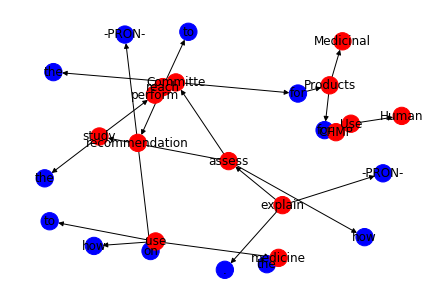

In [115]:
from nltk import Tree
import networkx as nx
from matplotlib import pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

d = {w1: {w2: 1 if w2 in w1.children else 0 for w2 in doc} for w1 in doc}
print(d)
g = nx.DiGraph()
g.add_nodes_from(d.keys())
for k, v in d.items():
    g.add_edges_from(([(k, t) for t,val in v.items() if val == 1]))
color_map = ["red" if w1.pos_ in ["NOUN","PROPN","VERB","ADJ"] else "blue" for w1 in doc]
nx.draw_spring(g,node_color=color_map,labels={w1:w1.lemma_ for w1 in doc})
plt.show()

{'it': 'PRP', 'explains': 'VERB', 'how': 'WRB', 'the': 'DT', 'committee': 'NOUN', 'for': 'IN', 'medicinal': 'ADJ', 'products': 'NOUN', 'human': 'ADJ', 'use': 'VERB', 'chmp': 'NOUN', 'assessed': 'VERB', 'studies': 'NOUN', 'performed': 'VERB', 'to': 'TO', 'reach': 'VERB', 'their': 'PRP$', 'recommendation': 'NOUN', 'on': 'IN', 'medicine': 'NOUN'}
['It', 'explains']
['explains', 'how']
['how', 'the']
['how', 'the', 'Committee']
['the', 'Committee']
['the', 'Committee', 'for']
['the', 'Committee', 'for', 'Medicinal']
['Committee', 'for']
['Committee', 'for', 'Medicinal']
['Committee', 'for', 'Medicinal', 'Products']
['Committee', 'for', 'Medicinal', 'Products', 'for']
['Committee', 'for', 'Medicinal', 'Products', 'for', 'Human']
['Committee', 'for', 'Medicinal', 'Products', 'for', 'Human', 'Use']
['Committee', 'for', 'Medicinal', 'Products', 'for', 'Human', 'Use', 'CHMP']
['CHMP', 'assessed']
['assessed', 'the']
['the', 'studies']
['studies', 'performed']
['performed', 'to']
['to', 'reach']

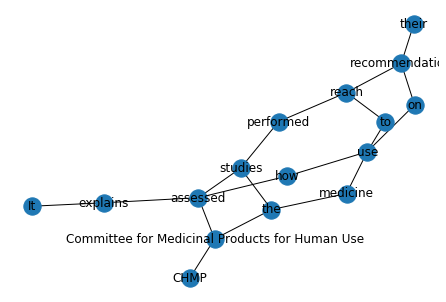

{'It': {'It': ['It'], 'explains': ['It', 'explains'], 'assessed': ['It', 'explains', 'assessed'], 'how': ['It', 'explains', 'assessed', 'how'], 'Committee for Medicinal Products for Human Use': ['It', 'explains', 'assessed', 'Committee for Medicinal Products for Human Use'], 'studies': ['It', 'explains', 'assessed', 'studies'], 'use': ['It', 'explains', 'assessed', 'how', 'use'], 'the': ['It', 'explains', 'assessed', 'Committee for Medicinal Products for Human Use', 'the'], 'CHMP': ['It', 'explains', 'assessed', 'Committee for Medicinal Products for Human Use', 'CHMP'], 'performed': ['It', 'explains', 'assessed', 'studies', 'performed'], 'on': ['It', 'explains', 'assessed', 'how', 'use', 'on'], 'to': ['It', 'explains', 'assessed', 'how', 'use', 'to'], 'medicine': ['It', 'explains', 'assessed', 'how', 'use', 'medicine'], 'reach': ['It', 'explains', 'assessed', 'studies', 'performed', 'reach'], 'recommendation': ['It', 'explains', 'assessed', 'how', 'use', 'on', 'recommendation'], 'their

In [164]:
from nltk import word_tokenize,pos_tag
import networkx as nx
from matplotlib import pyplot as plt
###### FUNCION entity_parser para sustituir a noun chunk 
def is_named_entity(synset):
    return synset_info(synset)["synsetType"] == "NAMED_ENTITY"

def advanced_search(chunk,pos=None):
    print(chunk.split())
    translate={
        "VERB":"v",
        "ADJ":"a",
        "NOUN":"n",
        "PROPN":"n",
        "ADV":"r"
    }
    try:
        if pos !=  None:
            return set.intersection(*[set([x for x in WORDS_TO_SYNSETS[word] if x[-1]==translate[pos]]) for word in chunk.split()])
        else:
            return set.intersection(*[set([x for x in WORDS_TO_SYNSETS[word]]) for word in chunk.split()])
        
    except KeyError:
        return set()


def filtered_synsets(word,synsets):
    if len(synsets) == 1:
        return synsets
    return [s for s in synsets if word in WORDS_TO_SYNSETS and s in WORDS_TO_SYNSETS[word]]

def paths(g,lex):
    d = nx.shortest_path(g) 
    print(d)
    new = {k1:{k2:len([n for n in v2 if n in lex]) for k2,v2 in v1.items() if k2 in lex} for k1,v1 in d.items() if k1 in lex}
    return new

def chunk_separate(chunk,pos_dict):
    print(chunk)
    chunk_words = [token.text for token in chunk if token.pos_ in ["VERB","NOUN","PROPN","ADJ"]]
    synsets = {}
    maps = {}
    if len(chunk_words) == 0:
        return chunk_words, d
    for i in range(len(chunk_words)):
        joint = ' '.join(chunk_words[i:])
        print(joint)
        matches = search_synsets(joint) if len(chunk_words[i:]) != 1 else filtered_synsets(chunk[-1].lemma_,search_synsets(chunk[-1].lemma_,pos="NOUN"))
        if len(matches) != 0:
            synsets[joint] = matches
            maps = {word:joint for word in chunk_words[i:]}
            break
        #else:
            #synsets[chunk_words[i]] = None     
    print(synsets,set(chunk_words[i:]),maps,joint)
    return synsets,set(chunk_words[i:]),maps,joint
 
def entity_parsing(sentence):
    mapped = {}
    synsets = {}
    matched = set()
    
    tokens = [token.text for token in nlp(sentence)] #extract tokens in sentence
    joint = ""
    for i,token in enumerate(tokens):
        if token in mapped: #already part of an entity
            continue
        else:
            if i == len(tokens) - 1:#the end
                break
            for j in range(i+1,len(tokens)):
                joint = " ".join(tokens[i:j+1]) # joint string
                syns =  [s for s in advanced_search(joint)]
                match = False
                exact_match = False
                exact_matches = []
                for s in syns:
                    references = BN[s]
                    for words in references:
                        if joint == words:
                            exact_match = True
                            exact_matches.append(s)
                        elif joint in words:
                            match = True
                        else:
                            continue           
                if exact_match:
                    for match in tokens[i:j+1]:
                        mapped[match] = joint
                    synsets[joint] = exact_matches
                elif match:
                    continue
                else:
                    break
    #print(synsets,set(chunk_words[i:]),maps,joint)
    return synsets,set(mapped.keys()),mapped,list(synsets.keys())
       

    
def analyze(sentence):
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    doc = nlp(sentence)
    pos = {key:pos_nltk_to_spacy(val) for key,val in pos_tag(word_tokenize(sentence.lower()))}
    print(pos)
    matched = set()
    maps = {}
    synsets = {}
    labels = {}
    root = []
    synsets,matched,maps,root = entity_parsing(sentence)
    for k in synsets:
        labels[k] = k
    """for chunk in doc.noun_chunks:
        if len(chunk) == 1:
            continue
        d,s,m,ent = chunk_separate(chunk,pos)
        if d == None:
            continue
        synsets.update(d)
        matched = matched.union(s)
        maps.update(m)
        root.append(ent)
        for k in d:
            labels[k] = k"""
    print(maps)
    for token in doc:
        if pos[token.text.lower()] in ["NOUN","PROPN","VERB","ADJ","ADV"]:
            root.append(token.text)
        if token.text not in matched:
            if pos[token.text.lower()] in ["NOUN","PROPN","VERB","ADJ","ADV"]:
                synsets[token.text] = search_synsets(token,pos=pos[token.text.lower()]) if pos[token.text.lower()] == "ADJ" or pos[token.text.lower()] == "PROPN" else search_synsets(token.lemma_,pos=pos[token.text.lower()])
                if pos[token.text.lower()] == "NOUN":
                    synsets[token.text] = filtered_synsets(token.lemma_,synsets[token.text])
                if pos[token.text.lower()] == "PROPN":
                    synsets[token.text] = filtered_synsets(token.text,synsets[token.text])
                if pos[token.text.lower()] == "VERB":
                    synsets[token.text] = filtered_synsets(token.lemma_,advanced_search(token.lemma_,pos="VERB"))
                    
                if len(synsets[token.text]) == 0:
                    synsets[token.text] = search_synsets(token)
            else:
                synsets[token.text] = []
            maps[token.text] = token.text
            labels[token.text] = token.text
    
    print(maps)
    
    M = {maps[w1.text]: {maps[w2.text]: 1 if w2.text in [x.text for x in w1.children] and maps[w1.text] != maps[w2.text]  else 0 
                    for w2 in doc} 
                         for w1 in doc}
    M = {}
    
    for w1 in doc:
        if maps[w1.text] not in M:
            M[maps[w1.text]] = {}
            for w2 in doc:
                if w2.text in [x.text for x in w1.children] and maps[w1.text] != maps[w2.text]:
                    M[maps[w1.text]][maps[w2.text]] = 1
        else:
            for w2 in doc:
                if w2.text in [x.text for x in w1.children] and maps[w1.text] != maps[w2.text]:
                    M[maps[w1.text]][maps[w2.text]] = 1
    
    g = nx.Graph()
    g.add_nodes_from(M.keys())
    for k, v in M.items():
        g.add_edges_from(([(k, t) for t,val in v.items() if val == 1]))
    
    return g,synsets,labels,root   

g,synsets,labels,lex = analyze("It explains how the Committee for Medicinal Products for Human Use (CHMP) assessed the studies performed to reach their recommendation on how to use the medicine.")   
#g,synsets,labels,lex = analyze("This document is a summary of the European Public Assessment Report, EPAR")
nx.draw_spring(g,labels=labels)
plt.show()
dist = paths(g,lex)

In [165]:
synsets

{'Committee for Medicinal Products for Human Use': ['bn:00302314n'],
 'It': [],
 'explains': ['bn:00087870v', 'bn:00087869v', 'bn:00087819v', 'bn:13690933v'],
 'how': [],
 'the': [],
 'CHMP': ['bn:00302314n'],
 'assessed': ['bn:00082853v', 'bn:00082852v', 'bn:00082720v', 'bn:00082854v'],
 'studies': ['bn:00067181n',
  'bn:00020448n',
  'bn:00074794n',
  'bn:00074795n',
  'bn:02020157n',
  'bn:00074790n',
  'bn:00007985n',
  'bn:00074791n',
  'bn:00074792n',
  'bn:00074793n',
  'bn:00071923n',
  'bn:00054145n'],
 'performed': ['bn:00091551v', 'bn:00087107v', 'bn:00087108v', 'bn:00091550v'],
 'to': [],
 'reach': ['bn:00092419v',
  'bn:00092418v',
  'bn:00092417v',
  'bn:00082788v',
  'bn:13740363v',
  'bn:00092415v',
  'bn:00092416v',
  'bn:00088825v',
  'bn:00087917v',
  'bn:00082790v',
  'bn:00088789v',
  'bn:00082226v',
  'bn:00087907v',
  'bn:00082901v',
  'bn:00085696v'],
 'their': [],
 'recommendation': ['bn:00066562n',
  'bn:00893309n',
  'bn:00041086n',
  'bn:00060926n'],
 'on': 

#### 

In [82]:
import pickle
with open("semantic_relations.p", "rb" ) as f:
    SEMANTIC_RELATIONS = pickle.load(f)
with open("babelnet_synsets.p", "rb") as f:
    BN = pickle.load(f)
with open("words_to_synsets.p", "rb") as f:
    WORDS_TO_SYNSETS = pickle.load(f)   

In [400]:
from itertools import combinations,product
from time import time

def mask(synset):
    pages = []
    translation = {}
    
    if synset not in SEMANTIC_RELATIONS:
        return None,None
    top = 10 if len(SEMANTIC_RELATIONS[synset]) > 10 else len(SEMANTIC_RELATIONS[synset])
    for s in SEMANTIC_RELATIONS[synset][:10]:
        page = wiki.page(BN[s])
        if s[-1] == 'n' and page.exists():
            pages.append(page)
            translation[page.title] = synset
    
    return pages,translation
    

def get_micro_corpus(synset):
    micro_corpus = []
    for x in synset_info(synset)["glosses"]:
        try:
            micro_corpus.append(x["gloss"])
        except KeyError:
            continue
    return " ".join(micro_corpus)

def set_synsets(synsets):
    senses = []
    dist_corr = {}
    mask_translation = {}
    for w,synsets in synsets.items():
        wiki_pages = []
        for idx in synsets:
            if idx[-1] == "n": #noun
                p = wiki_page(idx)
                if p != None and p.exists(): #has wikipedia page
                    wiki_pages.append(p)
                    dist_corr[p.title] = w #dictionary of lexical distance in sentence
                else: #non-existing page
                    cp = ComposedPage(idx,w)
                    wiki_pages.append(cp)
                    dist_corr[cp.title] = w
                    mask_translation[cp.title] = idx
                    
            else: #not noun
                if len(synsets) == 1: #only one meaning
                    wiki_pages.append(idx)
                    dist_corr[idx] = w
                else:
                    cp = ComposedPage(idx,w)
                    wiki_pages.append(cp)
                    dist_corr[cp.title] = w
                    mask_translation[cp.title] = idx
        
        sense = []
        i = 0
        for idx,page in zip(synsets,wiki_pages):
            print(f"{i}/{len(synsets)-1}")
            i += 1
            if type(page) == str:
                sense.append((idx,set_relevance(*stem_text(get_micro_corpus(page),title=w),sort=True)))
            else:
                sense.append((page.title,set_relevance(*stem_text(page.text,title=page.title.split("_")[0]),sort=True)))
        if len(sense) > 0:
            senses.append(sense)
    return senses,dist_corr,mask_translation           
                    


def possible_combs(senses,dist,corr,mask_translation):
    mx = 0
    ret = None
    d ={}
    for comb in product(*senses):
        score = 0
        for c in combinations(comb,2):
            word1,d1,word2,d2 = c[0][0],c[0][1],c[1][0],c[1][1]
            if (word1,word2) not in d:
                print(word1,word2)
                try:
                    dis = aa_distance(d1,d2)/dist[corr[word1]][corr[word2]]
                except ValueError:
                    dis = 0
                d[(word1,word2)] = dis
                d[(word2,word1)] = dis
            score += d[(word1,word2)]
        if score > mx:
            mx, ret = score, [ x for x,y in comb ]
    ret_translated = []
    for x in ret:
        if x in mask_translation:
            ret_translated.append(mask_translation[x])
        else:
            ret_translated.append(x)
    print(ret)
    return ret_translated,d

print("Starting analysis ... ")
#This document is a summary of the European Public Assessment Report, EPAR
g,synsets,labels,lex = analyze("It explains how the Committee for Medicinal Products for Human Use (CHMP) assessed the studies performed to reach their recommendation on how to use the medicine.")
dist = paths(g,lex)
senses,corr,mask_tr = set_synsets(synsets)
print("Disambiguating ... ")
ret,d = possible_combs(senses,dist,corr,mask_tr)
print(ret)
print(d)

Starting analysis ... 
{'it': 'PRP', 'explains': 'VERB', 'how': 'WRB', 'the': 'DT', 'committee': 'NOUN', 'for': 'IN', 'medicinal': 'ADJ', 'products': 'NOUN', 'human': 'ADJ', 'use': 'VERB', 'chmp': 'NOUN', 'assessed': 'VERB', 'studies': 'NOUN', 'performed': 'VERB', 'to': 'TO', 'reach': 'VERB', 'their': 'PRP$', 'recommendation': 'NOUN', 'on': 'IN', 'medicine': 'NOUN'}
['It', 'explains']
['explains', 'how']
['how', 'the']
['how', 'the', 'Committee']
['the', 'Committee']
['the', 'Committee', 'for']
['the', 'Committee', 'for', 'Medicinal']
['Committee', 'for']
['Committee', 'for', 'Medicinal']
['Committee', 'for', 'Medicinal', 'Products']
['Committee', 'for', 'Medicinal', 'Products', 'for']
['Committee', 'for', 'Medicinal', 'Products', 'for', 'Human']
['Committee', 'for', 'Medicinal', 'Products', 'for', 'Human', 'Use']
['Committee', 'for', 'Medicinal', 'Products', 'for', 'Human', 'Use', 'CHMP']
['CHMP', 'assessed']
['assessed', 'the']
['the', 'studies']
['studies', 'performed']
['performed'

0/0
0/2
1/2
2/2
0/0
0/3
1/3
2/3
3/3
0/1295
0/1295
0/1295
0/1295
0/1295
0/1295
0/1295
0/1295
0/1295
0/1295
0/1295
0/1295
0/1295
0/1295
0/1295
0/1295
0/1295
0/1295
0/1295
0/1295
0/1295
0/1295
0/1295
0/1295
0/1295
0/5
0/5
0/5
0/3
0/3
0/11
1/11
2/11
3/11
4/11
5/11
6/11
7/11
8/11
9/11
10/11
11/11
0/3
1/3
2/3
3/3
0/17
0/17
0/17
0/17
0/17
0/17
0/3
0/3
0/5
0/5
0/5
0/5
0/5
0/5
0/5
0/16
0/16
0/16
0/9
1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9
9/9
0/7
0/7
0/7
0/3
1/3
2/3
3/3
0/8
0/8
0/8
0/8
0/2
0/2
0/5
1/5
2/5
3/5
4/5
5/5
0/3
1/3
2/3
3/3
Disambiguating ... 
Committee for Medicinal Products for Human Use Explanation
Committee for Medicinal Products for Human Use Committee for Medicinal Products for Human Use
(('medicin', 'PROPN'), ('committe', 'PROPN'), ('product', 'PROPN'), ('chmp', 'PROPN'), ('agenc', 'PROPN'), ('human', 'PROPN'), ('european', 'PROPN'), ('cpmp', 'PROPN'), ('proprietari', 'PROPN'), ('veterinari', 'PROPN'), ('opinion', 'NOUN'), ('link', 'NOUN'), ('agenc', 'NOUN'), ('refer', 'NOUN'), ('produc

1375
155
[  8   9  47  35  22  13  19  37  34  27 126  32  85  16 189  57 172  24
  28  44 290 198  20  15 169] [ 17  41   5  14  29  52  48  45  66  88   7  97  23 133  11  65  15 147
 219 215  10  68 334 403  98]
[0.0, 10, inf]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Committee for Medicinal Products for Human Use Recommendation (European Union)
Explanation Recommendation (European Union)
(('case', 'NOUN'), ('kind', 'NOUN'), ('term', 'NOUN'), ('action', 'NOUN'), ('isbn', 'PROPN'), ('matter', 'NOUN'), ('link', 'NOUN'), ('refer', 'PROPN'))
294
89
8
[  9  43  61  85 106 215 205 245] [70 40 72 75 21 54 59 69]
[0.0, 10, inf]
[1 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0]
Tax Recommendation (European Union)
(('state', 'PROPN'), ('market', 'NOUN'), ('order', 'NOUN'), ('function', 'NOUN'), ('forc', 'NOUN'), ('countri', 'NOUN'), ('case', 'NOUN'), ('term', 'NOUN'), ('distort', 'NOUN'), ('develop', 'NOUN'), ('power', 'NOUN'), ('kind', 'NOUN'),

21
[ 525   22   45   76  775  180  504  532  617  632  718 1637 1250 1239
 1282 1599 1567 1643 1648 1672 1687] [ 13 105 103  70  14  94  69  99  53  82  48   9  43  67  73  63  71  78
  83  93  96]
[0.0, 10, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
Report reach out_bn:00092415v
Performance reach out_bn:00092415v
(('film', 'NOUN'), ('action', 'NOUN'), ('state', 'NOUN'), ('set', 'NOUN'), ('materi', 'NOUN'), ('drama', 'NOUN'), ('music', 'NOUN'))
447
108
7
[  6  58  80  86 324 346 415] [  1  78 105  96  63  68 101]
[0.0, 10, inf]
[1 0 0 0 0 0 0] [1 0 0 0 0 0 0]
reach out_bn:00092415v recommendation_bn:00066562n
(('seri', 'NOUN'), ('titl', 'NOUN'), ('band', 'NOUN'), ('album', 'NOUN'), ('rule', 'NOUN'), ('materi', 'NOUN'), ('set', 'NOUN'), ('game', 'NOUN'), ('peopl', 'NOUN'), ('action', 'NOUN'), ('music', 'NOUN'), ('disambigu', 'NOUN'))
108
192
11
[ 17  19  15  16  69  63  96 100 103  78 101 107] [ 17  12  94  99  68  71  91  98 100 175 185

Committee for Medicinal Products for Human Use study_bn:00020448n
Explanation study_bn:00020448n
Tax study_bn:00020448n
(('state', 'NOUN'), ('order', 'NOUN'), ('educ', 'NOUN'), ('studi', 'NOUN'), ('purchas', 'NOUN'), ('concept', 'NOUN'), ('organ', 'NOUN'), ('ancient', 'PROPN'), ('softwar', 'NOUN'))
1788
80
9
[  22   83  238  292  338  557  626  656 1554] [56 52 51 48 39 41 37 44 42]
[0.0, 10, inf]
[0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0]
study_bn:00020448n Performance
(('state', 'NOUN'), ('concept', 'NOUN'), ('studi', 'NOUN'), ('order', 'NOUN'), ('life', 'NOUN'))
80
447
5
[56 41 48 52 55] [ 80 200 378 411 416]
[0.0, 10, inf]
[0 0 0 0 0] [0 0 0 0 0]
study_bn:00020448n arrive_bn:00082788v
study_bn:00020448n recommendation_bn:00066562n
study_bn:00020448n Apply
study_bn:00020448n Medicine
(('treatment', 'NOUN'), ('organ', 'NOUN'), ('studi', 'NOUN'), ('educ', 'NOUN'), ('brain', 'NOUN'), ('order', 'NOUN'), ('concept', 'NOUN'), ('general', 'PROPN'), ('state', 'NOUN'), ('cancer', 'NOUN'), ('res

study_bn:00074794n Achievement
study_bn:00074794n reach out_bn:00092415v
study_bn:00074794n Striving
study_bn:00074794n get hold of_bn:00085696v
(('individu', 'NOUN'), ('process', 'NOUN'), ('time', 'NOUN'), ('organ', 'NOUN'), ('form', 'NOUN'), ('field', 'NOUN'), ('context', 'NOUN'), ('forc', 'NOUN'), ('order', 'NOUN'), ('entiti', 'NOUN'), ('exampl', 'NOUN'), ('valu', 'NOUN'), ('cooper', 'NOUN'), ('famili', 'NOUN'), ('peopl', 'NOUN'), ('viewpoint', 'NOUN'), ('group', 'NOUN'), ('thing', 'NOUN'), ('member', 'NOUN'), ('seri', 'NOUN'), ('concept', 'NOUN'), ('respons', 'NOUN'), ('law', 'NOUN'), ('histori', 'NOUN'), ('human', 'NOUN'))
294
626
43
[  0  15  20  48 188  46  24 181 193  33 182 149 138 202 229  90  22 142
 194 199   3   4   9  19  31] [123  21  32  20  19  83 121  79  85 131  95  99 105 111  88 124 144 133
 135 148 461 492 444 588 412]
[0.0, 10, inf]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
study_bn:00074794n Somatosen

[0 0 0 0 0 0 1 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0]
Étude gain_bn:00082790v
Committee for Medicinal Products for Human Use Endgame study
Explanation Endgame study
(('form', 'NOUN'), ('rule', 'NOUN'), ('fact', 'NOUN'), ('subject', 'NOUN'), ('richard', 'PROPN'), ('task', 'NOUN'), ('knowledg', 'NOUN'), ('isbn', 'PROPN'), ('sort', 'NOUN'), ('link', 'NOUN'), ('start', 'NOUN'), ('data', 'NOUN'), ('point', 'NOUN'))
294
384
13
[  3  89   2  20 257  40  44 106 134 205 255 263 272] [ 41  21 248 239  66 206 223  74 178 205 249 258 266]
[0.0, 10, inf]
[1 0 1 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0]
Tax Endgame study
(('exampl', 'NOUN'), ('studi', 'NOUN'), ('form', 'NOUN'), ('posit', 'NOUN'), ('number', 'NOUN'), ('rule', 'NOUN'), ('centuri', 'NOUN'), ('problem', 'NOUN'), ('rate', 'NOUN'), ('time', 'NOUN'), ('collect', 'NOUN'), ('year', 'NOUN'), ('point', 'NOUN'), ('introduct', 'NOUN'), ('fact', 'NOUN'), ('subject', 'NOUN'), ('result', 'NOUN'), ('data', 'NOUN'), ('program', 'NOUN'), ('cr

Committee for Medicinal Products for Human Use Research
Explanation Research
(('form', 'NOUN'), ('explan', 'NOUN'), ('knowledg', 'NOUN'), ('theori', 'NOUN'), ('question', 'NOUN'), ('issu', 'NOUN'), ('subject', 'NOUN'), ('scienc', 'NOUN'), ('fact', 'NOUN'), ('peopl', 'NOUN'), ('object', 'NOUN'), ('differ', 'NOUN'), ('kind', 'NOUN'), ('case', 'NOUN'), ('type', 'NOUN'), ('reason', 'NOUN'), ('analysi', 'NOUN'), ('context', 'NOUN'), ('model', 'NOUN'), ('discuss', 'NOUN'), ('difficulti', 'NOUN'), ('contrast', 'NOUN'), ('term', 'NOUN'), ('behavior', 'NOUN'), ('set', 'NOUN'))
294
1034
62
[ 3  0 44 18 23 46 20 21  2 48 11 13 43  9 24 15 73 27 31 38 69 66 61 55
 90] [  5 179   3   9  13  15  67  66 321  76 206 204  90 254 128 211  48 155
 156 191 185 252 273 327  79]
[0.0, 10, inf]
[1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] [1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Tax Research
(('form', 'NOUN'), ('exampl', 'NOUN'), ('countri', 'NOUN'), ('collect', 'NOUN'), ('data', 'NOUN'), (

Academic discipline arrive_bn:00082788v
(('scienc', 'NOUN'), ('time', 'NOUN'), ('centuri', 'NOUN'), ('art', 'NOUN'), ('term', 'NOUN'), ('theori', 'NOUN'), ('number', 'NOUN'), ('practic', 'NOUN'), ('design', 'NOUN'), ('shift', 'NOUN'), ('person', 'NOUN'), ('field', 'NOUN'), ('physic', 'NOUN'), ('histori', 'NOUN'), ('system', 'NOUN'), ('languag', 'NOUN'), ('countri', 'NOUN'), ('mechan', 'NOUN'), ('peopl', 'NOUN'), ('educ', 'NOUN'), ('social', 'PROPN'), ('societi', 'PROPN'), ('stage', 'NOUN'), ('movement', 'NOUN'), ('music', 'NOUN'))
683
497
48
[  4  18  36  26  39  29  67  90  74  83  46   3   6  13  21  42  47  53
  51  70  77  98 109 444 637] [ 34  50  52  65  60  67  63  58 116  92 167 364 325 467 457 432 415 309
 466 449 438 437 335   6  13]
[0.0, 10, inf]
[1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
Academic discipline recommendation_bn:00066562n
(('educ', 'NOUN'), ('studi', 'NOUN'), ('term', 'NOUN'), ('peopl', 'NOUN'), ('th

Meditation Employment
(('form', 'NOUN'), ('state', 'NOUN'), ('time', 'NOUN'), ('type', 'NOUN'), ('work', 'NOUN'), ('level', 'NOUN'), ('interest', 'NOUN'), ('studi', 'NOUN'), ('purpos', 'NOUN'), ('term', 'NOUN'), ('context', 'NOUN'), ('benefit', 'NOUN'), ('activ', 'NOUN'), ('hour', 'NOUN'), ('process', 'NOUN'), ('train', 'NOUN'), ('peopl', 'NOUN'), ('person', 'NOUN'), ('countri', 'NOUN'), ('period', 'NOUN'), ('field', 'NOUN'), ('instanc', 'NOUN'), ('system', 'NOUN'), ('bodi', 'NOUN'), ('approach', 'NOUN'))
1525
1054
138
[  9  12  39  31 306  84 139  63  45  41  53 154 189 257  82 127 134 196
 329 170 148  78  90  56 181] [ 31  32  13  26   3  16  23  51  82 104  97  36  24  30  85  60  89  45
  35  57  84 209 126 233  86]
[0.0, 10, inf]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Meditation Recommendation (European Union)
(('order', 'NOUN'), ('term', 'NOUN'), ('develop', 'NOUN'), ('power', 'NOUN'), ('action', 'NOUN'), ('countri

study_bn:00074792n get hold of_bn:00085696v
(('system', 'NOUN'), ('exampl', 'NOUN'), ('pattern', 'NOUN'), ('level', 'NOUN'), ('entiti', 'NOUN'), ('program', 'NOUN'), ('seri', 'NOUN'), ('languag', 'NOUN'), ('inform', 'NOUN'), ('media', 'NOUN'), ('form', 'NOUN'), ('organ', 'NOUN'), ('rule', 'NOUN'), ('time', 'NOUN'), ('properti', 'NOUN'), ('element', 'NOUN'), ('chang', 'NOUN'), ('disambigu', 'NOUN'), ('law', 'NOUN'), ('natur', 'NOUN'), ('type', 'NOUN'), ('album', 'NOUN'), ('group', 'NOUN'), ('unit', 'NOUN'), ('number', 'NOUN'))
370
626
46
[  6  28  78  60 103  99  59 318 315 312 334 300 276 355 250 219 302  30
  34  44  46  51 345  65  79] [ 17  95  71 142 131 141 148   4   6  10  19  20  33  32  43  44 128 357
 444 497 521 586 144 516 584]
[0.0, 10, inf]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
study_bn:00074792n Somatosensory system
(('system', 'NOUN'), ('type', 'NOUN'), ('amount', 'NOUN'), ('natur', 'NOUN'), ('inform', 'NO

Committee for Medicinal Products for Human Use Sketch (drawing)
Explanation Sketch (drawing)
(('term', 'NOUN'), ('peopl', 'NOUN'), ('form', 'NOUN'), ('object', 'NOUN'), ('subject', 'NOUN'), ('model', 'NOUN'), ('law', 'NOUN'), ('media', 'NOUN'), ('wikimedia', 'PROPN'), ('common', 'PROPN'), ('link', 'NOUN'), ('refer', 'PROPN'), ('degre', 'NOUN'))
294
169
13
[ 61  48   3  11  20  31  88 269 113 181 205 245 264] [  5  34 159 108 104 148 160  35  52  94 109 132 145]
[0.0, 10, inf]
[0 0 1 0 0 0 0 0 0 0 0 0 0] [1 0 0 0 0 0 0 0 0 0 0 0 0]
Tax Sketch (drawing)
(('term', 'NOUN'), ('purpos', 'NOUN'), ('work', 'NOUN'), ('studi', 'NOUN'), ('area', 'NOUN'), ('record', 'NOUN'), ('peopl', 'NOUN'), ('art', 'NOUN'), ('method', 'NOUN'), ('water', 'NOUN'), ('individu', 'NOUN'), ('form', 'NOUN'), ('product', 'NOUN'), ('law', 'NOUN'), ('author', 'NOUN'), ('chang', 'NOUN'), ('basi', 'NOUN'), ('number', 'NOUN'), ('principl', 'NOUN'), ('subject', 'NOUN'), ('abil', 'NOUN'), ('today', 'NOUN'), ('object', 'NOUN')

Committee for Medicinal Products for Human Use Assessment
Explanation Assessment
(('person', 'NOUN'), ('belief', 'NOUN'), ('knowledg', 'NOUN'), ('consequ', 'NOUN'), ('situat', 'NOUN'), ('data', 'NOUN'), ('assess', 'NOUN'))
294
71
6
[ 26  29  44 166 221 263 285] [13 29 50 26 48 59  0]
[0.0, 10, inf]
[0 0 0 0 0 0 0] [0 0 0 0 0 0 1]
Assessment Report
(('inform', 'NOUN'), ('system', 'NOUN'), ('consequ', 'NOUN'), ('skill', 'NOUN'), ('purpos', 'NOUN'), ('knowledg', 'NOUN'), ('plan', 'NOUN'), ('process', 'NOUN'))
71
214
8
[15 67 26 45 43 50 56 62] [ 14  44  95 133 145 150 147 186]
[0.0, 10, inf]
[0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0]
Assessment Performance
(('perform', 'NOUN'), ('skill', 'NOUN'), ('system', 'NOUN'), ('process', 'NOUN'), ('knowledg', 'NOUN'), ('person', 'NOUN'), ('psychologist', 'NOUN'), ('belief', 'NOUN'), ('psycholog', 'NOUN'), ('practic', 'NOUN'))
71
447
10
[63 45 67 62 50 13 22 29 34 41] [  0  11  36  59  74 267 183 260 262 362]
[0.0, 10, inf]
[0 0 0 0 0 0 0 0 0 0] [1 0 0 0 0

Assessment study_bn:00074794n
Assessment Étude
(('collect', 'NOUN'), ('situat', 'NOUN'), ('practic', 'NOUN'), ('skill', 'NOUN'), ('perform', 'NOUN'), ('write', 'NOUN'))
71
276
6
[58 48 41 45 63 60] [  2  38  53 162 156 238]
[0.0, 10, inf]
[0 0 0 0 0 0] [1 0 0 0 0 0]
Assessment Endgame study
Assessment Research
(('data', 'NOUN'), ('inform', 'NOUN'), ('knowledg', 'NOUN'), ('process', 'NOUN'), ('journal', 'NOUN'), ('collect', 'NOUN'), ('purpos', 'NOUN'), ('practic', 'NOUN'), ('amount', 'NOUN'), ('system', 'NOUN'), ('status', 'NOUN'), ('technolog', 'NOUN'), ('assess', 'NOUN'), ('person', 'NOUN'), ('health', 'NOUN'), ('consequ', 'NOUN'), ('examin', 'NOUN'), ('market', 'NOUN'), ('impact', 'NOUN'), ('perform', 'NOUN'), ('health', 'PROPN'))
71
1034
21
[59 15 50 62 12 58 43 41 31 67 55 35  0 13 14 26 32 42 52 63 64] [  1  14   3  11  84  22  32 113 218 251 286 353 698 886 941 650 684 764
 590 935 942]
[0.0, 10, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0] [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [191]:
senses



[[('Committee for Medicinal Products for Human Use',
   {('committe', 'PROPN'): {'words': set(),
     'occurr': [1, 13, 44, 55, 67],
     'relevance': 6.05695918139329e-05,
     'pos': 1},
    ('medicin', 'PROPN'): {'words': {'medicinal'},
     'occurr': [3, 16, 23, 46, 57, 64, 69],
     'relevance': 8.522273285069578e-05,
     'pos': 0},
    ('product', 'PROPN'): {'words': set(),
     'occurr': [4, 17, 47, 58, 70],
     'relevance': 4.8570724750265096e-05,
     'pos': 2},
    ('human', 'PROPN'): {'words': set(),
     'occurr': [6, 60, 72],
     'relevance': 2.4222859126413602e-05,
     'pos': 5},
    ('chmp', 'PROPN'): {'words': set(),
     'occurr': [8, 62, 74],
     'relevance': 2.4352431261667836e-05,
     'pos': 3},
    ('proprietari', 'PROPN'): {'words': set(),
     'occurr': [15],
     'relevance': 1.217395317041498e-05,
     'pos': 10},
    ('cpmp', 'PROPN'): {'words': set(),
     'occurr': [18],
     'relevance': 1.2176222520750283e-05,
     'pos': 7},
    ('european', 'PROPN'

In [106]:
00054128n
    

(S
  It/PRP
  explains/VBZ
  how/WRB
  the/DT
  Committe/NNP
  for/IN
  Medicinal/NNP
  Products/NNPS
  for/IN
  Human/NNP
  Use/NNP
  (/(
  CHMP/NNP
  )/)
  assessed/VBD
  the/DT
  studies/NNS
  performed/VBD
  to/TO
  reach/VB
  their/PRP$
  (NP recommendation/NN)
  on/IN
  how/WRB
  to/TO
  use/VB
  (NP the/DT medicine/NN)
  ./.)


['Committe', 'Medicinal Products', 'Human Use', 'CHMP']

In [410]:


def entity_parsing(sentence):
    mapped = {}
    synsets = {}
    matched = set()
    
    tokens = [token.text for token in nlp(sentence)] #extract tokens in sentence
    joint = ""
    for i,token in enumerate(tokens):
        if token in mapped: #already part of an entity
            continue
        else:
            if i == len(tokens) - 1:#the end
                break
            for j in range(i+1,len(tokens)):
                joint = " ".join(tokens[i:j+1]) # joint string
                syns =  [s for s in advanced_search(joint) if s != None]
                match = False
                exact_match = False
                exact_matches = []
                for s in syns:
                    references = BN[s]
                    for words in references:
                        if joint == words:
                            exact_match = True
                            exact_matches.append(s)
                        elif joint in words:
                            match = True
                        else:
                            continue           
                if exact_match:
                    for match in tokens[i:j+1]:
                        mapped[match] = joint
                    synsets[joint] = exact_matches
                elif match:
                    continue
                else:
                    break
    return synsets,set(mapped.keys()),mapped,synsets.keys()

#synsets,set(chunk_words[i:]),maps,joint 


""" d,s,m,ent = chunk_separate(chunk,pos)
        if d == None:
            continue
        synsets.update(d)
        matched = matched.union(s)
        maps.update(m)
        root.append(ent)
        for k in d:
            labels[k] = k """

sentence = "The Windmills of Your Mind is an amazing song"
entity_parsing(sentence)            


['The', 'Windmills']
['The', 'Windmills', 'of']
['The', 'Windmills', 'of', 'Your']
['The', 'Windmills', 'of', 'Your', 'Mind']
['The', 'Windmills', 'of', 'Your', 'Mind', 'is']
['is', 'an']
['is', 'an', 'amazing']
['an', 'amazing']
['amazing', 'song']


({'The Windmills of Your Mind': ['bn:15180320n', 'bn:03760458n']},
 {'Mind', 'The', 'Windmills', 'Your', 'of'},
 {'The': 'The Windmills of Your Mind',
  'Windmills': 'The Windmills of Your Mind',
  'of': 'The Windmills of Your Mind',
  'Your': 'The Windmills of Your Mind',
  'Mind': 'The Windmills of Your Mind'},
 dict_keys(['The Windmills of Your Mind']))

In [91]:
def compose_page_from_edges(synset,word):
    text = ""
    for edge in SEMANTIC_RELATIONS[synset]:
        p = None if edge not in BN else wiki.page(BN[edge][0])
        if edge[-1]=='n' and p != None and p.exists():
            text += p.text
    return set_relevance(*stem_text(text,title=word),sort=True)




def get_mask_page(synset,word):
    pages = []
    choose = []
    partial = {}
    for edge in SEMANTIC_RELATIONS[synset]:
        p = None if edge not in BN else wiki.page(BN[edge][0])
        if edge[-1]=='n' and p != None and p.exists():
            pages.append(p)
    for alternative in set(BN[synset]):
        possibilities = search_synsets(alternative)
        for pos in possibilities:
            if pos[-1] != 'n':
                continue
            if pos in BN:
                st = BN[pos][0] if BN[pos][0] != word or len(BN[pos]) == 1 else BN[pos][1]
                p1 = wiki.page(st)
                d1 = set_relevance(*stem_text(p1.text,title=p1.title),sort=True)
            else:
                continue

            choose.append((pos,sum([aa_distance(d1,set_relevance(*stem_text(p2.text,title=p2.title),sort=True)) for p2 in pages])))

    print(choose)
    print(pages)
    return sorted(choose,key=lambda x: x[1])[-1]

d_comp= compose_page_from_edges("bn:00005120n","assessment")
p1 = wiki.page("Educational assessment")
d1 = set_relevance(*stem_text(p1.text,title="assessment"),sort=True)
p2 = wiki.page("Public")
d2 = set_relevance(*stem_text(p2.text,title="public"),sort=True)
aa_distance(d1,d2) 


(('set', 'NOUN'), ('school', 'NOUN'), ('individu', 'NOUN'), ('group', 'NOUN'), ('state', 'NOUN'), ('communiti', 'NOUN'), ('centuri', 'NOUN'), ('field', 'NOUN'), ('technolog', 'NOUN'), ('order', 'NOUN'), ('situat', 'NOUN'), ('system', 'NOUN'), ('univers', 'PROPN'), ('practic', 'NOUN'), ('year', 'NOUN'), ('respons', 'NOUN'), ('progress', 'NOUN'), ('subject', 'NOUN'), ('matter', 'NOUN'), ('paper', 'NOUN'), ('issu', 'NOUN'), ('critic', 'NOUN'), ('inform', 'NOUN'), ('curriculum', 'NOUN'), ('materi', 'NOUN'))
871
311
57
[ 30  13  92 234  89 105 184  87 159 194 235 103 288  11  32  48  51  71
  70  77  96 100 101 102 119] [ 16  54   8   3  50  27  47  65  59  58  28  66  49 190 289 192 138  78
 208 230 246 187 266 172 244]
[0.0, 10, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


2.0800313969372906

In [78]:
choose = [('bn:00530022n', 0), ('bn:00059480n', 88.38329272844584), ('bn:00924974n', 0), ('bn:00022052n', 0), ('bn:03541131n', 33.35725569526902), ('bn:00022054n', 18.955447800835593), ('bn:00021406n', 0), ('bn:00022055n', 0), ('bn:03158261n', 0), ('bn:03009067n', 30.26892434300305), ('bn:02922993n', 35.10475883036916), ('bn:02398553n', 18.441946301235358), ('bn:02436267n', 0), ('bn:00464082n', 29.600917826751754), ('bn:00977461n', 20.362277660168377), ('bn:16605235n', 0), ('bn:03313710n', 62.348041471994875), ('bn:00021399n', 27.015066373040774), ('bn:01229716n', 37.312203008172176), ('bn:00021410n', 48.54541965933172), ('bn:00021398n', 27.015066373040774), ('bn:00021411n', 8.44160088073789), ('bn:17283100n', 8.44160088073789), ('bn:00018760n', 0), ('bn:00021406n', 0), ('bn:00021407n', 8.44160088073789), ('bn:00021408n', 33.52814728392364), ('bn:16479209n', 8.44160088073789), ('bn:00021409n', 45.34250373214449), ('bn:14667928n', 8.44160088073789), ('bn:14790964n', 24.296002496878355), ('bn:00347961n', 0), ('bn:00000777n', 21.954403727696572), ('bn:00007306n', 40.71035924041442), ('bn:00021406n', 0), ('bn:00052906n', 46.915177506180015), ('bn:00052907n', 46.915177506180015), ('bn:00021406n', 0), ('bn:00052906n', 46.915177506180015), ('bn:00052907n', 46.915177506180015), ('bn:14555401n', 46.915177506180015), ('bn:00599493n', 46.915177506180015), ('bn:14030378n', 46.915177506180015), ('bn:00021406n', 0)]

In [79]:
sorted(choose,key=lambda x: x[1])

[('bn:00530022n', 0),
 ('bn:00924974n', 0),
 ('bn:00022052n', 0),
 ('bn:00021406n', 0),
 ('bn:00022055n', 0),
 ('bn:03158261n', 0),
 ('bn:02436267n', 0),
 ('bn:16605235n', 0),
 ('bn:00018760n', 0),
 ('bn:00021406n', 0),
 ('bn:00347961n', 0),
 ('bn:00021406n', 0),
 ('bn:00021406n', 0),
 ('bn:00021406n', 0),
 ('bn:00021411n', 8.44160088073789),
 ('bn:17283100n', 8.44160088073789),
 ('bn:00021407n', 8.44160088073789),
 ('bn:16479209n', 8.44160088073789),
 ('bn:14667928n', 8.44160088073789),
 ('bn:02398553n', 18.441946301235358),
 ('bn:00022054n', 18.955447800835593),
 ('bn:00977461n', 20.362277660168377),
 ('bn:00000777n', 21.954403727696572),
 ('bn:14790964n', 24.296002496878355),
 ('bn:00021399n', 27.015066373040774),
 ('bn:00021398n', 27.015066373040774),
 ('bn:00464082n', 29.600917826751754),
 ('bn:03009067n', 30.26892434300305),
 ('bn:03541131n', 33.35725569526902),
 ('bn:00021408n', 33.52814728392364),
 ('bn:02922993n', 35.10475883036916),
 ('bn:01229716n', 37.312203008172176),
 ('b

"Educational assessment or educational evaluation is the systematic process of documenting and using empirical data on the knowledge, skill, attitudes, and beliefs to refine programs and improve student learning. Assessment data can be obtained from directly examining student work to assess the achievement of learning outcomes or can be based on data from which one can make inferences about learning. Assessment is often used interchangeably with test, but not limited to tests. Assessment can focus on the individual learner, the learning community (class, workshop, or other organized group of learners), a course, an academic program, the institution, or the educational system as a whole (also known as granularity). The word 'assessment' came into use in an educational context after the Second World War.As a continuous process, assessment establishes measurable and clear student learning outcomes for learning, provisioning a sufficient amount of learning opportunities to achieve these ou

In [399]:
def disambiguate_nouns(synsets,nouns,distance_dic):
    for noun,base_form in nouns:
        votes = []
        fathers = sorted([k for k in distance_dic if k not in [x[0] for x in nouns]], key=lambda x: distance_dic[noun][x] if x != noun else np.inf)
        out = 1
        while distance_dic[noun][fathers[0]] == distance_dic[noun][fathers[out]]:
            out += 1
        fathers = fathers[:out] #to vote
        i = 0
        print(fathers)
        for s in synsets[noun]:
            print(f"{i}/{len(synsets[noun])-1}")
            i+=1
            p = wiki.page(BN[s][0]) if s in BN else None
            text = p.text if p != None and p.exists() else ComposedPage(s,base_form).text
            if base_form not in BN[s]:
                continue
            vote = sum([text.count(f) for f in fathers])
            votes.append((vote,s))
        print(votes)
        print(sorted(votes)[-1])
            
sentence = "It explains how the Committee for Medicinal Products for Human Use (CHMP) assessed the studies performed to reach their recommendation on how to use the medicine."
#g,synsets,labels,lex = analyze(sentence)
#dist = paths(g,lex)
print(synsets)
disambiguate_nouns(synsets,[("medicine","medicine"),("studies","study")],dist)

{'Committee for Medicinal Products for Human Use': ['bn:00302314n'], 'It': [], 'explains': ['bn:00087870v', 'bn:00087819v', 'bn:00087869v'], 'how': [], 'the': [], 'CHMP': ['bn:00302314n'], 'assessed': ['bn:00082853v', 'bn:00082852v', 'bn:00082720v', 'bn:00082854v'], 'studies': ['bn:00067181n', 'bn:00020448n', 'bn:00074794n', 'bn:00074795n', 'bn:02020157n', 'bn:00074790n', 'bn:00007985n', 'bn:00074791n', 'bn:00074792n', 'bn:00074793n', 'bn:00071923n', 'bn:00054145n'], 'performedto': [], 'reach': ['bn:00082788v', 'bn:00088789v', 'bn:00082901v', 'bn:00082226v', 'bn:00092415v', 'bn:00092416v', 'bn:00085696v', 'bn:00087917v', 'bn:00088825v', 'bn:00082790v'], 'their': [], 'recommendation': ['bn:00066562n', 'bn:00893309n', 'bn:00041086n', 'bn:00060926n'], 'on': [], 'to': [], 'use': ['bn:00082711v', 'bn:00089140v', 'bn:00087859v', 'bn:00095474v', 'bn:00095475v', 'bn:00082705v'], 'medicine': ['bn:00054133n', 'bn:00054134n', 'bn:00054126n', 'bn:00054128n']}
['Committee for Medicinal Products for

In [339]:
synsets

{'Committee for Medicinal Products for Human Use': ['bn:00302314n'],
 'It': [],
 'explains': ['bn:00087870v', 'bn:00087819v', 'bn:00087869v'],
 'how': [],
 'the': [],
 'CHMP': ['bn:00302314n'],
 'assessed': ['bn:00082853v', 'bn:00082852v', 'bn:00082720v', 'bn:00082854v'],
 'studies': ['bn:00067181n',
  'bn:00020448n',
  'bn:00074794n',
  'bn:00074795n',
  'bn:02020157n',
  'bn:00074790n',
  'bn:00007985n',
  'bn:00074791n',
  'bn:00074792n',
  'bn:00074793n',
  'bn:00071923n',
  'bn:00054145n'],
 'performedto': [],
 'reach': ['bn:00082788v',
  'bn:00088789v',
  'bn:00082901v',
  'bn:00082226v',
  'bn:00092415v',
  'bn:00092416v',
  'bn:00085696v',
  'bn:00087917v',
  'bn:00088825v',
  'bn:00082790v'],
 'their': [],
 'recommendation': ['bn:00066562n',
  'bn:00893309n',
  'bn:00041086n',
  'bn:00060926n'],
 'on': [],
 'to': [],
 'use': ['bn:00082711v',
  'bn:00089140v',
  'bn:00087859v',
  'bn:00095474v',
  'bn:00095475v',
  'bn:00082705v'],
 'medicine': ['bn:00054133n', 'bn:00054134n', 

In [118]:
#################### TEST OF ENTROPY MODELS ######################

def get_micro_corpus(synset):
    micro_corpus = []
    for x in synset_info(synset)["glosses"]:
        try:
            micro_corpus.append(x["gloss"])
        except KeyError:
            continue
    return " ".join(micro_corpus)

def is_disambiguation_page(page,word):
    return page.text == wiki.page(f'{word} (disambiguation)').text

class ComposedPage:
    def __init__(self,synset,word):
        self.text = ""
        if synset in BN:
            for word in BN[synset]:
                p = wiki.page(word)
                if p.exists() and not is_disambiguation_page(p,word):
                    self.title = p.title
                    self.text = p.text
                    break
        if self.text == "":
            self.title = f"{word}_{synset}"
            i = 0
            if synset not in SEMANTIC_RELATIONS:
                self.text = ""
            else:
                rels = sorted(SEMANTIC_RELATIONS[synset], key=lambda x: len(SEMANTIC_RELATIONS[x]) if x in SEMANTIC_RELATIONS else 0, reverse=True)[:30]
                for edge in rels:
                    if edge[-1]!='n':
                        continue
                    print(f"{i}/{len(SEMANTIC_RELATIONS[synset])-1}")
                    for word in BN[synset]:
                        p = wiki.page(word)
                        if p.exists() and not is_disambiguation_page(p,word):
                            self.text += " ".join(p.text.split(" ")[:int(10000/len(rels))])
    def dictionary(self,):           
        if self.text == "":
            return None
        return set_relevance(*stem_text(self.text,title=self.title),sort=True)
        
#cp = ComposedPage("bn:00083187v","make up")
#cp = wiki.page("Physician")
#d_comp = set_relevance(*stem_text(cp.text,title=cp.title),sort=True)



def entropy(probs):
    """ Entropy function (0 case covered)"""
    return -np.sum(probs * np.log2(probs + (probs == 0).astype(int)))

probs = np.array([0.1,0.1,0.4,0.2,0])
entropy(np.array(probs))

def entropy_state(source_glosses,dest_glosses,dictionary_rel):
    M = {}
    total = 0
    for k_d,v_d in dest_glosses.items():
        M[k_d] = 0
        for k_s,v_s in source_glosses.items():
            if v_s == 1:
                print("#####",aa_distance(dictionary_rel[k_s],dictionary_rel[k_d]),v_s)
            new_dist =  v_s*aa_distance(dictionary_rel[k_s],dictionary_rel[k_d])*distance_2(k_d,k_s,6,dictionary_rel[k_d],dictionary_rel[k_s])
            total += new_dist
            M[k_d] += new_dist
    for k_d,v_d in M.items(): 
        M[k_d] = v_d/total
    
    return M


In [126]:
"""S1,S2 = synsets["use"],synsets["medicine"]
pages_rel = {}
for word,val in synsets.items():
    for synset in val:
        d = ComposedPage(synset,word).dictionary()
        pages_rel[synset] = d 

dest_glosses = {k:1/len(S2) for k in S2}
source_glosses = {k:0 for k in S1}"""
test = []
for k in source_glosses:
    source_glosses[k] = 1
    vals = np.array(list(entropy_state(source_glosses,dest_glosses,pages_rel).values()))
    print("#"*90)
    test.append((entropy(vals),k))
    print("#"*90)
    source_glosses[k] = 0
sorted(test)

##### 0 1
4
107
(('organ', 'NOUN'), ('system', 'NOUN'), ('sex', 'NOUN'), ('anim', 'NOUN'), ('develop', 'NOUN'), ('human', 'NOUN'), ('order', 'NOUN'), ('differ', 'NOUN'), ('individu', 'NOUN'), ('level', 'NOUN'), ('structur', 'NOUN'), ('plant', 'NOUN'), ('practic', 'NOUN'), ('exampl', 'NOUN'), ('evid', 'NOUN'), ('bodi', 'NOUN'), ('form', 'NOUN'), ('process', 'NOUN'), ('way', 'NOUN'), ('access', 'NOUN'), ('part', 'NOUN'), ('cord', 'NOUN'), ('pregnanc', 'NOUN'), ('gene', 'NOUN'), ('chang', 'NOUN'))
1732
251
58
[ 12   6 267  84  38 183 124 145 354 413 189 571   7  16  59  66  67  72
 158 164 166 281 294 328 362] [  5  19   0  18  45   9  38  50  44  32  57  43 213 226 206 223 230 222
 184 212 219  96 140 149 221]
[0.0, 10, inf]
[0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('organ', 'NOUN'), ('system', 'NOUN'), ('sex', 'NOUN'), ('anim', 'NOUN'), ('develop', 'NOUN'), ('human', 'NOUN'), ('order', 'NOUN'), ('differ', 'NOUN'), ('individ

(('exampl', 'NOUN'), ('time', 'NOUN'), ('version', 'NOUN'), ('attempt', 'NOUN'), ('number', 'NOUN'), ('peopl', 'NOUN'), ('person', 'NOUN'), ('term', 'NOUN'), ('charact', 'NOUN'), ('set', 'NOUN'), ('face', 'NOUN'), ('attent', 'NOUN'), ('case', 'NOUN'), ('realiti', 'NOUN'), ('editor', 'NOUN'), ('citi', 'PROPN'), ('singer', 'PROPN'), ('necess', 'NOUN'), ('luck', 'NOUN'), ('antholog', 'PROPN'), ('crimin', 'NOUN'), ('volum', 'NOUN'), ('link', 'NOUN'), ('aid', 'NOUN'), ('refer', 'NOUN'))
241
1742
29
[ 37  29  22  12  30 227 191 209 208 156 119 165 184 145 167 229 186  81
  98 104  89 159 148 155 170] [   8   64  158  274  442    6   11   28  201  202  353  351  400  510
  534  557  606 1087 1114 1182 1443 1329 1411 1441 1457]
[0.0, 10, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('exampl', 'NOUN'), ('practic', 'NOUN'), ('theori', 'NOUN'), ('ethic', 'NOUN'), ('studi', 'NOUN'), ('principl', 'NOUN'), ('care', 'NOUN'), ('system', 

 219 156 227] [  18   22  368    2   34   50   56   75  224  234  355  470  866 1080
 1090 1134 1177 1258 1167 1283 1298]
[0.0, 10, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('system', 'NOUN'), ('bodi', 'NOUN'), ('time', 'NOUN'), ('object', 'NOUN'), ('practic', 'NOUN'), ('studi', 'NOUN'), ('centuri', 'NOUN'), ('work', 'NOUN'), ('process', 'NOUN'), ('term', 'NOUN'), ('exampl', 'NOUN'), ('histori', 'NOUN'), ('theori', 'NOUN'), ('period', 'NOUN'), ('popul', 'NOUN'), ('condit', 'NOUN'), ('year', 'NOUN'), ('order', 'NOUN'), ('form', 'NOUN'), ('eye', 'NOUN'), ('evid', 'NOUN'), ('discoveri', 'NOUN'), ('age', 'NOUN'), ('materi', 'NOUN'), ('list', 'NOUN'))
1732
1423
173
[  6  66 120 298   7  19 129  36  72  93  16  21 102 203  83  27 378 124
  67  92  59 452  99 341 144] [ 14  19  18   5 228 124  27  99  80  75 368 251  90  53 174 415  56 135
 375 234 413  43 379 106 238]
[0.0, 10, inf]
[1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0]
(('number', 'NOUN'), ('music', 'NOUN'), ('exampl', 'NOUN'), ('time', 'NOUN'), ('attempt', 'NOUN'), ('peopl', 'NOUN'), ('term', 'NOUN'), ('product', 'NOUN'), ('realiti', 'NOUN'), ('link', 'NOUN'), ('case', 'NOUN'), ('refer', 'NOUN'), ('person', 'NOUN'), ('film', 'NOUN'), ('inabl', 'NOUN'), ('monro', 'PROPN'), ('stanley', 'PROPN'), ('skill', 'NOUN'), ('audienc', 'NOUN'), ('combin', 'NOUN'), ('face', 'NOUN'), ('attent', 'NOUN'), ('perform', 'NOUN'), ('charact', 'NOUN'), ('set', 'NOUN'))
241
1074
26
[ 30  34  37  29  12 227 209 219 145 148 184 170 191   1  83 103 128 110
 157 146 119 165 211 208 156] [  42   96   34  218  257   31   48   93  189  191  247  344  349 1033
  645  696  806  859  736  849  937  923  912  991 1018]
[0.0, 10, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('work', 'NOUN'), ('studi', 'NOUN'), ('theor

1
1
1
1
1
1
1
1
1
(('function', 'NOUN'), ('list', 'NOUN'), ('scienc', 'NOUN'), ('exampl', 'NOUN'), ('theori', 'NOUN'), ('method', 'NOUN'), ('applic', 'NOUN'), ('object', 'NOUN'), ('categori', 'NOUN'), ('place', 'NOUN'), ('studi', 'NOUN'), ('bodi', 'NOUN'), ('case', 'NOUN'), ('order', 'NOUN'), ('form', 'NOUN'), ('role', 'NOUN'), ('time', 'NOUN'), ('oper', 'NOUN'), ('differ', 'NOUN'), ('evalu', 'NOUN'), ('interpret', 'NOUN'), ('compon', 'NOUN'), ('chang', 'NOUN'), ('conflict', 'NOUN'), ('array', 'NOUN'))
241
1732
37
[  0   3  36  47  10  20  46   9  19  49  96  62  30  92 210 209 214 163
 173 152 160 170 199 185   5] [  47  144   17   16  102  138   62  298  202  105   19   66  349  124
   67  111  120  128  145  299  310  319  362  467 1198]
[0.0, 10, inf]
[1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
9
115
(('number', 'NOUN'), ('order', 'NOUN'), ('argument', 'NOUN'), ('exampl', 'NOUN'), ('bodi', 'NOUN'), ('differ', 'NOUN'), ('co

(('countri', 'NOUN'), ('system', 'NOUN'), ('area', 'NOUN'), ('develop', 'NOUN'), ('unit', 'PROPN'), ('scienc', 'NOUN'), ('centuri', 'NOUN'), ('europ', 'PROPN'), ('state', 'PROPN'), ('care', 'NOUN'), ('histori', 'NOUN'), ('health', 'NOUN'), ('popul', 'NOUN'), ('author', 'NOUN'), ('exampl', 'NOUN'), ('time', 'NOUN'), ('work', 'NOUN'), ('diseas', 'NOUN'), ('year', 'NOUN'), ('term', 'NOUN'), ('state', 'NOUN'), ('educ', 'NOUN'), ('period', 'NOUN'), ('depart', 'NOUN'), ('member', 'NOUN'))
1732
4007
354
[ 23   6  45  38  80  17 129 194  79   8  21  10  83 169  16 120  36   3
 378  93 373  76 203  56 381] [  4  87  34  48  13 104   6   3  26 394 158 364  43  20 271  39 133 820
   8  97  15 140  33 213  19]
[0.0, 10, inf]
[0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] [1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
(('countri', 'NOUN'), ('system', 'NOUN'), ('area', 'NOUN'), ('develop', 'NOUN'), ('unit', 'PROPN'), ('scienc', 'NOUN'), ('centuri', 'NOUN'), ('europ', 'PROPN'), ('state', 'P

(('exampl', 'NOUN'), ('thing', 'NOUN'), ('order', 'NOUN'), ('time', 'NOUN'), ('busi', 'NOUN'), ('account', 'NOUN'), ('servic', 'NOUN'), ('labor', 'NOUN'), ('materi', 'NOUN'), ('case', 'NOUN'), ('societi', 'NOUN'), ('categori', 'NOUN'), ('peopl', 'NOUN'), ('term', 'NOUN'), ('valu', 'NOUN'), ('individu', 'NOUN'), ('decis', 'NOUN'), ('field', 'NOUN'), ('applic', 'NOUN'), ('william', 'PROPN'), ('basi', 'NOUN'), ('model', 'NOUN'), ('futur', 'NOUN'), ('contrast', 'NOUN'), ('theori', 'PROPN'))
241
1742
43
[ 39  21  15  27  10  42  16  14  51  52  45  48 229 205 156 191 193 215
  74 213 182 106 203 149 196] [  8  22  84  64 211 108 380 550 356 400 611 603   6  28  38  41  54 103
 157 160 182 233 239 337 359]
[0.0, 10, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
(('exampl', 'NOUN'), ('practic', 'NOUN'), ('theori', 'NOUN'), ('ethic', 'NOUN'), ('studi', 'NOUN'), ('principl', 'NOUN'), ('care', 'NOUN'), ('system', 'NOUN'), ('knowledg'

[ 27  21  15  39  48  45  16 229 205 225 220 156 215 175 106 191 119 193
 182 184 230 226 196 231   1] [  14   43  137   56   34  251  490    3   10   64  147  169  229  246
  261  262  338  355  391  393  375  423  621  608 1631]
[0.0, 10, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('practic', 'NOUN'), ('system', 'NOUN'), ('studi', 'NOUN'), ('exampl', 'NOUN'), ('countri', 'NOUN'), ('term', 'NOUN'), ('histori', 'NOUN'), ('form', 'NOUN'), ('centuri', 'NOUN'), ('time', 'NOUN'), ('scienc', 'NOUN'), ('cultur', 'NOUN'), ('law', 'NOUN'), ('disciplin', 'NOUN'), ('organ', 'NOUN'), ('develop', 'NOUN'), ('concept', 'NOUN'), ('place', 'NOUN'), ('tradit', 'NOUN'), ('popul', 'NOUN'), ('theori', 'NOUN'), ('work', 'NOUN'), ('field', 'NOUN'), ('aspect', 'NOUN'), ('categori', 'NOUN'))
1732
1888
260
[  7   6  19  16  23  93  21  67 129 120  17 174 159  37  12  38 218 105
 312  83 102  36  40 176 202] [  4  36  16  56  38  10  60  21   8 

(('product', 'NOUN'), ('time', 'NOUN'), ('exampl', 'NOUN'), ('result', 'NOUN'), ('societi', 'NOUN'), ('metric', 'NOUN'), ('indic', 'NOUN'), ('individu', 'NOUN'), ('term', 'NOUN'), ('peopl', 'NOUN'), ('field', 'NOUN'), ('univers', 'PROPN'), ('employ', 'NOUN'), ('govern', 'NOUN'), ('rate', 'NOUN'), ('order', 'NOUN'), ('thing', 'NOUN'), ('opportun', 'NOUN'), ('econom', 'NOUN'), ('project', 'NOUN'), ('water', 'NOUN'), ('categori', 'NOUN'), ('materi', 'NOUN'), ('case', 'NOUN'), ('percept', 'NOUN'))
241
639
33
[  1  27  39  20  45  46  96 191 205 229 215 231 142 226 145  15  21  22
  31 212  44  48  51  52 110] [123  26  38  58  50 183  14  16  37  41  60  65  67  73 115 589 503 465
 450 197 585 423 489 574 349]
[0.0, 10, inf]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('health', 'NOUN'), ('countri', 'NOUN'), ('organ', 'NOUN'), ('qualiti', 'NOUN'), ('exampl', 'NOUN'), ('diseas', 'NOUN'), ('patient', 'NOUN'), ('system', 'NOUN'), ('

1
1
1
##### 0 1
4
0/80
0/80
0/80
0/80
1
1
1
1
1
1
1
1
1
(('work', 'NOUN'), ('form', 'NOUN'), ('time', 'NOUN'), ('type', 'NOUN'), ('exampl', 'NOUN'), ('activ', 'NOUN'), ('countri', 'NOUN'), ('perform', 'NOUN'), ('organ', 'NOUN'), ('studi', 'NOUN'), ('period', 'NOUN'), ('structur', 'NOUN'), ('number', 'NOUN'), ('term', 'NOUN'), ('peopl', 'NOUN'), ('group', 'NOUN'), ('unit', 'PROPN'), ('case', 'NOUN'), ('state', 'PROPN'), ('relationship', 'NOUN'), ('state', 'NOUN'), ('industri', 'NOUN'), ('system', 'NOUN'), ('individu', 'NOUN'), ('chang', 'NOUN'))
1054
2460
214
[  3  31  13  26  76  24  34 198  28  51  56 128  81 104  89 111   8  75
   9  18  32  27 126 120 214] [ 17   5  30  21  13  86  74   8 107  70  72  38  80  73  85  62 587 110
 594 340 316 324  81  95  71]
[0.0, 10, inf]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0] [0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39
670
(('time', 'NOUN'), ('form', 'NOUN'), ('level', 'NOUN'), ('work', 'NOUN'), ('number', 'NOUN'), ('labor',

(('peopl', 'NOUN'), ('system', 'NOUN'), ('person', 'NOUN'), ('role', 'NOUN'), ('time', 'NOUN'), ('posit', 'NOUN'), ('studi', 'NOUN'), ('stem', 'NOUN'), ('level', 'NOUN'), ('area', 'NOUN'), ('fact', 'NOUN'), ('low', 'PROPN'), ('children', 'NOUN'), ('tendenc', 'NOUN'), ('exampl', 'NOUN'), ('form', 'NOUN'), ('number', 'NOUN'), ('case', 'NOUN'), ('countri', 'NOUN'), ('order', 'NOUN'), ('media', 'NOUN'), ('part', 'NOUN'), ('tabl', 'NOUN'), ('process', 'NOUN'), ('region', 'NOUN'))
423
1969
58
[  8  15  11  29  63  76  38  62  26  96  56  65 109  45 386 396 406 384
 376 400 381 370 333 379 332] [ 36  65 126  71  48  80 274 251 343 195 368 414 282 738   4   5  11  14
  24  30 182 190 214 219 276]
[0.0, 10, inf]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0]
(('form', 'NOUN'), ('exampl', 'NOUN'), ('centuri', 'NOUN'), ('time', 'NOUN'), ('number', 'NOUN'), ('sound', 'NOUN'), ('countri', 'NOUN'), ('languag', 'NOUN'), ('case', 'NOUN'), ('chan

0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
(('form', 'NOUN'), ('exampl', 'NOUN'), ('centuri', 'NOUN'), ('time', 'NOUN'), ('system', 'NOUN'), ('state', 'NOUN'), ('peopl', 'NOUN'), ('individu', 'NOUN'), ('countri', 'NOUN'), ('term', 'NOUN'), ('histori', 'NOUN'), ('law', 'NOUN'), ('group', 'NOUN'), ('activ', 'NOUN'), ('case', 'NOUN'), ('theori', 'NOUN'), ('communiti', 'NOUN'), ('type', 'NOUN'), ('definit', 'NOUN'), ('studi', 'NOUN'), ('tradit', 'NOUN'), ('natur', 'NOUN'), ('role', 'NOUN'), ('develop', 'NOUN'), ('court', 'NOUN'))
2460
1300
231
[  5  13  15  30  81 316  85  95  74  73  46 698  62  86 110 123 135  21
 153  70  59 253  67  69 422] [ 15  24  29  20   5   2  26  22  46  48 108   0  93  74  61  60  56 291
  62 145 204  47 254 259  12]
[0.0, 10, inf]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

(('tax', 'NOUN'), ('govern', 'NOUN'), ('term', 'NOUN'), ('place', 'NOUN'), ('servic', 'NOUN'), ('england', 'PROPN'), ('type', 'NOUN'), ('exampl', 'NOUN'), ('differenti', 'NOUN'), ('entiti', 'NOUN'), ('individu', 'NOUN'), ('compani', 'NOUN'), ('york', 'PROPN'), ('peopl', 'NOUN'))
241
330
14
[ 61 226 205 225  16 216 184  39 109 119 191 228 224 229] [ 88   2   6  22 288  57  61 278 154 180 251 260 300 307]
[0.0, 10, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 1 1 0 0 0 0 0 0 0 0 0 0 0]
(('term', 'NOUN'), ('countri', 'NOUN'), ('area', 'NOUN'), ('state', 'NOUN'), ('type', 'NOUN'), ('communiti', 'NOUN'), ('unit', 'NOUN'), ('part', 'NOUN'), ('place', 'NOUN'), ('unit', 'PROPN'), ('languag', 'NOUN'), ('church', 'NOUN'), ('word', 'NOUN'), ('state', 'PROPN'), ('incom', 'NOUN'), ('law', 'NOUN'), ('australia', 'PROPN'), ('divis', 'NOUN'), ('power', 'NOUN'), ('china', 'PROPN'), ('form', 'NOUN'), ('exampl', 'NOUN'), ('structur', 'NOUN'), ('number', 'NOUN'), ('system', 'NOUN'))
2460
330
70
[ 73  74 104 316 

(('number', 'NOUN'), ('exampl', 'NOUN'), ('set', 'NOUN'), ('term', 'NOUN'), ('case', 'NOUN'), ('year', 'NOUN'), ('angl', 'NOUN'), ('line', 'NOUN'), ('attempt', 'NOUN'), ('time', 'NOUN'), ('realiti', 'NOUN'), ('link', 'NOUN'), ('techniqu', 'NOUN'), ('multipl', 'NOUN'), ('aid', 'NOUN'), ('start', 'NOUN'), ('day', 'NOUN'), ('seri', 'NOUN'))
241
685
18
[ 30  37 156 209 184 230  88 192  12  29 145 148 149 175 155 150 224 226] [ 24   5   1  38  72  96 162 206 566 611 515 517 519 355 528 577 618 622]
[0.0, 10, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('theori', 'NOUN'), ('system', 'NOUN'), ('exampl', 'NOUN'), ('knowledg', 'NOUN'), ('field', 'NOUN'), ('set', 'NOUN'), ('develop', 'NOUN'), ('scienc', 'NOUN'), ('number', 'NOUN'), ('studi', 'NOUN'), ('experi', 'NOUN'), ('role', 'NOUN'), ('year', 'NOUN'), ('foundat', 'NOUN'), ('term', 'NOUN'), ('method', 'NOUN'), ('case', 'NOUN'), ('group', 'NOUN'), ('applic', 'NOUN'), ('form', 'NOUN'), ('principl', 'NOUN'),

(('matter', 'NOUN'), ('studi', 'NOUN'), ('exampl', 'NOUN'), ('chemic', 'NOUN'), ('process', 'NOUN'), ('live', 'NOUN'), ('mixtur', 'NOUN'), ('link', 'NOUN'), ('scale', 'NOUN'), ('condit', 'NOUN'), ('energi', 'NOUN'))
423
140
11
[118  38 386 246 379 385 273 317 324 351 366] [ 29 127   6   8  16  17  78  92  98 112 124]
[0.0, 10, inf]
[0 0 0 0 0 0 0 0 0 0 0] [0 0 1 1 0 0 0 0 0 0 0]
(('materi', 'NOUN'), ('exampl', 'NOUN'), ('properti', 'NOUN'), ('applic', 'NOUN'), ('classif', 'NOUN'), ('process', 'NOUN'), ('chemic', 'NOUN'), ('term', 'NOUN'), ('behavior', 'NOUN'), ('scienc', 'NOUN'), ('studi', 'NOUN'), ('condit', 'NOUN'), ('function', 'NOUN'), ('way', 'NOUN'), ('element', 'NOUN'), ('measur', 'NOUN'), ('metal', 'NOUN'), ('refer', 'NOUN'), ('forc', 'NOUN'), ('product', 'NOUN'), ('introduct', 'NOUN'), ('live', 'NOUN'), ('substanc', 'NOUN'), ('mixtur', 'NOUN'), ('synthesi', 'NOUN'))
2961
140
33
[ 427   52  421  286  511  296  444  202  779   26   28   49  165  311
  314  350  541  610  663  69

1
(('time', 'NOUN'), ('studi', 'NOUN'), ('exampl', 'NOUN'), ('theori', 'NOUN'), ('respons', 'NOUN'), ('process', 'NOUN'), ('organ', 'NOUN'), ('system', 'NOUN'), ('form', 'NOUN'), ('anim', 'NOUN'), ('experi', 'NOUN'), ('condit', 'NOUN'), ('behavior', 'NOUN'), ('case', 'NOUN'), ('factor', 'NOUN'), ('research', 'NOUN'), ('diseas', 'NOUN'), ('procedur', 'NOUN'), ('human', 'NOUN'), ('brain', 'NOUN'), ('increas', 'NOUN'), ('life', 'NOUN'), ('observ', 'NOUN'), ('effect', 'NOUN'), ('drug', 'NOUN'))
850
2961
173
[ 28   9  10  27   1   3  26 102  24  13  58  82   5  67  43  18 287  32
  50  78  36 216 140  47 110] [  5  28  52  23 366 296  79  10 135 269  56  49 779 138 283 583   6 463
 343 189 635  54 150 453 178]
[0.0, 10, inf]
[0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
10
(('behavior', 'NOUN'), ('process', 'NOUN'), ('exampl', 'NOUN'), ('studi', 'NOUN'), ('habit', 'NOUN'), ('time', 'NOUN'), ('experi', 'NOUN'), ('increas', 'NOUN'), ('

(('materi', 'NOUN'), ('process', 'NOUN'), ('exampl', 'NOUN'), ('product', 'NOUN'), ('manufactur', 'NOUN'), ('input', 'NOUN'), ('applic', 'NOUN'), ('term', 'NOUN'), ('way', 'NOUN'), ('function', 'NOUN'))
241
140
10
[ 51   9  39   1   5  25  74 205 160 186] [  0  16   6 116  91  61   3  30 101 109]
[0.0, 10, inf]
[0 1 0 1 1 0 0 0 0 0] [1 0 1 0 0 0 1 0 0 0]
(('materi', 'NOUN'), ('exampl', 'NOUN'), ('properti', 'NOUN'), ('applic', 'NOUN'), ('classif', 'NOUN'), ('process', 'NOUN'), ('chemic', 'NOUN'), ('term', 'NOUN'), ('behavior', 'NOUN'), ('scienc', 'NOUN'), ('studi', 'NOUN'), ('condit', 'NOUN'), ('function', 'NOUN'), ('way', 'NOUN'), ('element', 'NOUN'), ('measur', 'NOUN'), ('metal', 'NOUN'), ('refer', 'NOUN'), ('forc', 'NOUN'), ('product', 'NOUN'), ('introduct', 'NOUN'), ('live', 'NOUN'), ('substanc', 'NOUN'), ('mixtur', 'NOUN'), ('synthesi', 'NOUN'))
2961
140
33
[ 427   52  421  286  511  296  444  202  779   26   28   49  165  311
  314  350  541  610  663  695  992 2633 1963 1619 213

1
##### 0 1
4
107
(('unit', 'PROPN'), ('state', 'PROPN'), ('countri', 'NOUN'), ('franc', 'PROPN'), ('develop', 'NOUN'), ('govern', 'NOUN'), ('physician', 'NOUN'), ('nation', 'PROPN'), ('time', 'NOUN'), ('year', 'NOUN'), ('australia', 'PROPN'), ('trial', 'NOUN'), ('sale', 'NOUN'), ('war', 'PROPN'), ('state', 'NOUN'), ('scientist', 'NOUN'), ('kingdom', 'PROPN'), ('japan', 'PROPN'), ('candid', 'NOUN'), ('centuri', 'NOUN'), ('manag', 'NOUN'), ('intern', 'PROPN'), ('peopl', 'NOUN'), ('design', 'NOUN'), ('canada', 'PROPN'))
1375
2506
116
[ 17  41  14 105  10  52  44 133  53 114 238  78  79 347  97 100 102 258
 246 117 334 240 242 314 216] [  7  10  60  34 394 130 181  63 179 114  74 337 318  52 402 288 235 150
 171 231  67 190 216 126 377]
[0.0, 10, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('unit', 'PROPN'), ('state', 'PROPN'), ('countri', 'NOUN'), ('franc', 'PROPN'), ('develop', 'NOUN'), ('govern', 'NOUN'), ('physician', '

1
1
1
1
(('unit', 'PROPN'), ('state', 'PROPN'), ('product', 'NOUN'), ('countri', 'NOUN'), ('law', 'NOUN'), ('time', 'NOUN'), ('market', 'NOUN'), ('growth', 'NOUN'), ('industri', 'NOUN'), ('system', 'NOUN'), ('compani', 'NOUN'), ('state', 'NOUN'), ('process', 'NOUN'), ('level', 'NOUN'), ('effect', 'NOUN'), ('period', 'NOUN'), ('manufactur', 'NOUN'), ('activ', 'NOUN'), ('organ', 'NOUN'), ('condit', 'NOUN'), ('develop', 'NOUN'), ('class', 'NOUN'), ('manag', 'NOUN'), ('trade', 'NOUN'), ('agenc', 'NOUN'))
1054
1375
155
[  8   9  47  34  23  13  19  37  27 126  36  32  85  15 191  56 171  24
  28  44 290 184  20  16 186] [ 17  41   5  14  29  53  48  45  88   7  67  97  23 132  11  64  15 146
 218 223  10  66 334 404  98]
[0.0, 10, inf]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39
670
(('countri', 'NOUN'), ('unit', 'PROPN'), ('incom', 'NOUN'), ('level', 'NOUN'), ('economi', 'NOUN'), ('member', 'NOUN'), ('product', 'NOUN'), ('secto

(('studi', 'NOUN'), ('work', 'NOUN'), ('field', 'NOUN'), ('system', 'NOUN'), ('process', 'NOUN'), ('time', 'NOUN'), ('number', 'NOUN'), ('relationship', 'NOUN'), ('program', 'NOUN'), ('issu', 'NOUN'), ('state', 'NOUN'), ('term', 'NOUN'), ('manag', 'NOUN'), ('approach', 'NOUN'), ('type', 'NOUN'), ('organ', 'NOUN'), ('form', 'NOUN'), ('structur', 'NOUN'), ('model', 'NOUN'), ('exampl', 'NOUN'), ('test', 'NOUN'), ('limit', 'NOUN'), ('task', 'NOUN'), ('creation', 'NOUN'), ('develop', 'NOUN'))
1054
955
136
[ 51   3  84 126  85  13  81  18 139  49  32 104  20  86  26  28  31 128
 262  76 125  66 129 102 290] [  8 100   6   3  12 103  25 111  20  75 121  40 198  57 147 167 208  58
  30 124  79 179 108 145  43]
[0.0, 10, inf]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('system', 'NOUN'), ('process', 'NOUN'), ('develop', 'NOUN'), ('scienc', 'NOUN'), ('effect', 'NOUN'), ('design', 'NOUN'), ('data', 'NOUN'), ('number', 'NOUN'), ('field'

(('form', 'NOUN'), ('servic', 'NOUN'), ('work', 'NOUN'), ('market', 'NOUN'), ('industri', 'NOUN'), ('state', 'PROPN'), ('time', 'NOUN'), ('peopl', 'NOUN'), ('product', 'NOUN'), ('exampl', 'NOUN'), ('type', 'NOUN'), ('unit', 'PROPN'), ('term', 'NOUN'), ('issu', 'NOUN'), ('busi', 'NOUN'), ('organ', 'NOUN'), ('activ', 'NOUN'), ('countri', 'NOUN'), ('number', 'NOUN'), ('compani', 'NOUN'), ('system', 'NOUN'), ('level', 'NOUN'), ('person', 'NOUN'), ('program', 'NOUN'), ('relat', 'NOUN'))
1054
1510
208
[ 31  17   3  19  27   9  13  89  47  76  26   8 104  49  61  28  24  34
  81  36 126  15  45 139  71] [  4  28 123  31  32  93  61   7  26  12  47 152  13  43  44 118 150 114
  57 124  42 293 178  68 134]
[0.0, 10, inf]
[0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('product', 'NOUN'), ('system', 'NOUN'), ('market', 'NOUN'), ('develop', 'NOUN'), ('peopl', 'NOUN'), ('term', 'NOUN'), ('industri', 'NOUN'), ('countri', 'NOUN'), ('time', 'N

[0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] [1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('busi', 'NOUN'), ('compani', 'NOUN'), ('law', 'NOUN'), ('employe', 'NOUN'), ('manag', 'NOUN'), ('worker', 'NOUN'), ('type', 'NOUN'), ('organ', 'NOUN'), ('servic', 'NOUN'), ('activ', 'NOUN'), ('market', 'NOUN'), ('form', 'NOUN'), ('exampl', 'NOUN'), ('product', 'NOUN'), ('countri', 'NOUN'), ('labor', 'NOUN'), ('person', 'NOUN'), ('time', 'NOUN'), ('trade', 'NOUN'), ('employ', 'NOUN'), ('member', 'NOUN'), ('state', 'PROPN'), ('capit', 'NOUN'), ('peopl', 'NOUN'), ('profit', 'NOUN'))
1054
821
198
[ 61  36  23   1  20   4  26  28  17  24  19  31  76  47  34   6  45  13
  16   0 103   9  77  89  64] [  0   1   8  63   9  81  17  21  27  24  29  23  15  37  51 169  42  99
 100 283  18 135  31  34  49]
[0.0, 10, inf]
[0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0] [1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('compani', 'NOUN'), ('law', 'NOUN'), ('product', 'NOUN'), ('jurisdict

(('number', 'NOUN'), ('exampl', 'NOUN'), ('refer', 'NOUN'), ('line', 'NOUN'), ('term', 'NOUN'))
241
115
5
[ 30  37 170 192 209] [14  8 77 86 90]
[0.0, 10, inf]
[0 0 0 0 0] [0 1 0 0 0]
(('system', 'NOUN'), ('number', 'NOUN'), ('instanc', 'NOUN'), ('system', 'PROPN'), ('unit', 'PROPN'), ('state', 'PROPN'), ('term', 'NOUN'), ('method', 'NOUN'), ('australia', 'PROPN'), ('way', 'NOUN'), ('degre', 'NOUN'), ('ambigu', 'NOUN'), ('entiti', 'NOUN'), ('usag', 'NOUN'), ('settlement', 'NOUN'))
1375
115
15
[   7  241  288  276   17   41  143  219  238  243 1204  760  932  993
  990] [ 10  14  12  19 109 108  90  67  94  65   7  29  51  57  76]
[0.0, 10, inf]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
(('number', 'NOUN'), ('exampl', 'NOUN'), ('refer', 'NOUN'), ('line', 'NOUN'), ('term', 'NOUN'))
241
115
5
[ 30  37 170 192 209] [14  8 77 86 90]
[0.0, 10, inf]
[0 0 0 0 0] [0 1 0 0 0]
(('system', 'NOUN'), ('number', 'NOUN'), ('instanc', 'NOUN'), ('system', 'PROPN'), ('unit', 'PROPN'

1
1
1
1
(('list', 'NOUN'), ('function', 'NOUN'), ('categori', 'NOUN'), ('method', 'NOUN'), ('number', 'NOUN'), ('applic', 'NOUN'), ('case', 'NOUN'), ('scienc', 'NOUN'), ('bodi', 'NOUN'), ('properti', 'NOUN'), ('program', 'NOUN'), ('studi', 'NOUN'), ('time', 'NOUN'), ('result', 'NOUN'), ('role', 'NOUN'), ('form', 'NOUN'), ('compon', 'NOUN'), ('object', 'NOUN'), ('scheme', 'PROPN'), ('path', 'NOUN'), ('order', 'NOUN'), ('oper', 'NOUN'), ('sequenc', 'NOUN'), ('differ', 'NOUN'), ('version', 'NOUN'))
241
1375
25
[  3   0  19  20  53  46  30  36  62  91  17  96 214 204 209 210 170   9
  55  83  92 163 176 173 207] [ 107  326   30  219  241  317  408  346  233  156  423  405   53  254
  296  366  374  803 1046 1044 1254  763  772 1036 1233]
[0.0, 10, inf]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
9
115
(('program', 'NOUN'), ('case', 'NOUN'), ('comput', 'NOUN'), ('scienc', 'NOUN'), ('common', 'PROPN'), ('time', 'NOUN'), ('version', 

(('peopl', 'NOUN'), ('system', 'NOUN'), ('person', 'NOUN'), ('role', 'NOUN'), ('time', 'NOUN'), ('posit', 'NOUN'), ('studi', 'NOUN'), ('stem', 'NOUN'), ('level', 'NOUN'), ('area', 'NOUN'), ('fact', 'NOUN'), ('low', 'PROPN'), ('children', 'NOUN'), ('tendenc', 'NOUN'), ('exampl', 'NOUN'), ('form', 'NOUN'), ('number', 'NOUN'), ('case', 'NOUN'), ('countri', 'NOUN'), ('order', 'NOUN'), ('media', 'NOUN'), ('part', 'NOUN'), ('tabl', 'NOUN'), ('process', 'NOUN'), ('region', 'NOUN'))
423
1969
58
[  8  15  11  29  63  76  38  62  26  96  56  65 109  45 386 396 406 384
 376 400 381 370 333 379 332] [ 36  65 126  71  48  80 274 251 343 195 368 414 282 738   4   5  11  14
  24  30 182 190 214 219 276]
[0.0, 10, inf]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0]
(('countri', 'NOUN'), ('system', 'NOUN'), ('unit', 'PROPN'), ('time', 'NOUN'), ('state', 'PROPN'), ('class', 'NOUN'), ('number', 'NOUN'), ('form', 'NOUN'), ('period', 'NOUN'), ('centu

(('countri', 'NOUN'), ('unit', 'PROPN'), ('franc', 'PROPN'), ('develop', 'NOUN'), ('system', 'NOUN'), ('state', 'PROPN'), ('centuri', 'NOUN'), ('year', 'NOUN'), ('state', 'NOUN'), ('govern', 'NOUN'), ('time', 'NOUN'), ('period', 'NOUN'), ('product', 'NOUN'), ('law', 'NOUN'), ('nation', 'PROPN'), ('kingdom', 'PROPN'), ('process', 'NOUN'), ('peopl', 'NOUN'), ('control', 'NOUN'), ('number', 'NOUN'), ('term', 'NOUN'), ('market', 'NOUN'), ('group', 'NOUN'), ('growth', 'NOUN'), ('war', 'PROPN'))
1375
4007
233
[ 14  17 105  10   7  41 117 114  97  52  53  64   5  29 133 102  23 242
  96 241 143  48 281  45 347] [  4  13   0  48  87  26   6   8  15  40  39  33 371 151  29  66 247  49
 134  61  97 349  65 478  32]
[0.0, 10, inf]
[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('countri', 'NOUN'), ('unit', 'PROPN'), ('franc', 'PROPN'), ('develop', 'NOUN'), ('system', 'NOUN'), ('state', 'PROPN'), ('centuri', 'NOUN'), ('year', 'NOUN'), ('sta

(('respons', 'NOUN'), ('rate', 'NOUN'), ('chang', 'NOUN'), ('amount', 'NOUN'), ('increas', 'NOUN'), ('anim', 'NOUN'), ('human', 'NOUN'), ('effect', 'NOUN'), ('mechan', 'NOUN'), ('brain', 'NOUN'), ('system', 'NOUN'), ('reflex', 'NOUN'), ('case', 'NOUN'), ('disord', 'NOUN'), ('condit', 'NOUN'), ('term', 'NOUN'), ('result', 'NOUN'), ('diseas', 'NOUN'), ('instanc', 'NOUN'), ('life', 'NOUN'), ('place', 'NOUN'), ('express', 'NOUN'), ('posit', 'NOUN'), ('pattern', 'NOUN'), ('process', 'NOUN'))
850
753
81
[  1  65  14  45  36  13  50  47  83  78 102  84  67  79  82 176 168 287
 295 216 299 251 261 296   3] [ 97   6  62  39  59 141  43  58  37  64  74  92 163 133 166 114 150  68
  69 197 177 227 224 233 248]
[0.0, 10, inf]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('system', 'NOUN'), ('effect', 'NOUN'), ('rate', 'NOUN'), ('blood', 'NOUN'), ('diseas', 'NOUN'), ('level', 'NOUN'), ('disord', 'NOUN'), ('regul', 'NOUN'), ('product', 'NOU

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars


(('materi', 'NOUN'), ('process', 'NOUN'), ('exampl', 'NOUN'), ('product', 'NOUN'), ('manufactur', 'NOUN'), ('input', 'NOUN'), ('applic', 'NOUN'), ('term', 'NOUN'), ('way', 'NOUN'), ('function', 'NOUN'))
241
140
10
[ 51   9  39   1   5  25  74 205 160 186] [  0  16   6 116  91  61   3  30 101 109]
[0.0, 10, inf]
[0 1 0 1 1 0 0 0 0 0] [1 0 1 0 0 0 1 0 0 0]
(('properti', 'NOUN'), ('process', 'NOUN'), ('chemic', 'NOUN'), ('classif', 'NOUN'), ('applic', 'NOUN'), ('substanc', 'NOUN'), ('term', 'NOUN'), ('behavior', 'NOUN'), ('product', 'NOUN'), ('manufactur', 'NOUN'), ('synthesi', 'NOUN'), ('industri', 'NOUN'), ('origin', 'NOUN'), ('combin', 'NOUN'), ('introduct', 'NOUN'), ('condit', 'NOUN'), ('way', 'NOUN'), ('function', 'NOUN'), ('scienc', 'NOUN'), ('studi', 'NOUN'), ('structur', 'NOUN'), ('metal', 'NOUN'), ('object', 'NOUN'), ('select', 'NOUN'), ('link', 'NOUN'))
1375
140
25
[ 156   23   56  118  317   31  143  210    5   15   63   88  125  154
  214  223  243  326  346  405 1199  876  80

(('organ', 'NOUN'), ('system', 'NOUN'), ('sex', 'NOUN'), ('anim', 'NOUN'), ('develop', 'NOUN'), ('human', 'NOUN'), ('order', 'NOUN'), ('differ', 'NOUN'), ('individu', 'NOUN'), ('level', 'NOUN'), ('structur', 'NOUN'), ('plant', 'NOUN'), ('practic', 'NOUN'), ('exampl', 'NOUN'), ('evid', 'NOUN'), ('bodi', 'NOUN'), ('form', 'NOUN'), ('process', 'NOUN'), ('way', 'NOUN'), ('access', 'NOUN'), ('part', 'NOUN'), ('cord', 'NOUN'), ('pregnanc', 'NOUN'), ('gene', 'NOUN'), ('chang', 'NOUN'))
1732
251
58
[ 12   6 267  84  38 183 124 145 354 413 189 571   7  16  59  66  67  72
 158 164 166 281 294 328 362] [  5  19   0  18  45   9  38  50  44  32  57  43 213 226 206 223 230 222
 184 212 219  96 140 149 221]
[0.0, 10, inf]
[0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('organ', 'NOUN'), ('system', 'NOUN'), ('sex', 'NOUN'), ('anim', 'NOUN'), ('develop', 'NOUN'), ('human', 'NOUN'), ('order', 'NOUN'), ('differ', 'NOUN'), ('individu', 'NOUN'), ('l

(('exampl', 'NOUN'), ('time', 'NOUN'), ('version', 'NOUN'), ('attempt', 'NOUN'), ('number', 'NOUN'), ('peopl', 'NOUN'), ('person', 'NOUN'), ('term', 'NOUN'), ('charact', 'NOUN'), ('set', 'NOUN'), ('face', 'NOUN'), ('attent', 'NOUN'), ('case', 'NOUN'), ('realiti', 'NOUN'), ('editor', 'NOUN'), ('citi', 'PROPN'), ('singer', 'PROPN'), ('necess', 'NOUN'), ('luck', 'NOUN'), ('antholog', 'PROPN'), ('crimin', 'NOUN'), ('volum', 'NOUN'), ('link', 'NOUN'), ('aid', 'NOUN'), ('refer', 'NOUN'))
241
1742
29
[ 37  29  22  12  30 227 191 209 208 156 119 165 184 145 167 229 186  81
  98 104  89 159 148 155 170] [   8   64  158  274  442    6   11   28  201  202  353  351  400  510
  534  557  606 1087 1114 1182 1443 1329 1411 1441 1457]
[0.0, 10, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('exampl', 'NOUN'), ('practic', 'NOUN'), ('theori', 'NOUN'), ('ethic', 'NOUN'), ('studi', 'NOUN'), ('principl', 'NOUN'), ('care', 'NOUN'), ('system', 

  67  92  59 452  99 341 144] [ 14  19  18   5 228 124  27  99  80  75 368 251  90  53 174 415  56 135
 375 234 413  43 379 106 238]
[0.0, 10, inf]
[1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('time', 'NOUN'), ('number', 'NOUN'), ('exampl', 'NOUN'), ('star', 'NOUN'), ('format', 'NOUN'), ('day', 'NOUN'), ('year', 'NOUN'), ('term', 'NOUN'), ('refer', 'NOUN'), ('eye', 'NOUN'), ('face', 'NOUN'), ('angl', 'NOUN'), ('necess', 'NOUN'), ('stage', 'NOUN'), ('link', 'NOUN'), ('volum', 'NOUN'), ('effect', 'NOUN'), ('releas', 'NOUN'), ('product', 'NOUN'), ('set', 'NOUN'), ('peopl', 'NOUN'))
241
1423
21
[ 29  30  37 202 166 224 230 209 170 138 119  88  81 141 148 159 169 130
 219 156 227] [  18   22  368    2   34   50   56   75  224  234  355  470  866 1080
 1090 1134 1177 1258 1167 1283 1298]
[0.0, 10, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('system', 'NOUN'), ('bodi', 'NOUN'), ('ti

(('term', 'NOUN'), ('exampl', 'NOUN'), ('form', 'NOUN'), ('practic', 'NOUN'), ('relationship', 'NOUN'), ('system', 'NOUN'), ('care', 'NOUN'), ('heart', 'NOUN'), ('time', 'NOUN'), ('concept', 'NOUN'), ('person', 'NOUN'), ('work', 'NOUN'), ('theori', 'NOUN'), ('develop', 'NOUN'), ('human', 'NOUN'), ('famili', 'NOUN'), ('condit', 'NOUN'), ('principl', 'NOUN'), ('author', 'NOUN'), ('univers', 'NOUN'), ('centuri', 'NOUN'), ('activ', 'NOUN'), ('school', 'NOUN'), ('basi', 'NOUN'), ('scienc', 'NOUN'))
1732
1400
200
[ 93  16  67   7 132   6   8 122 120 218 180  36 102  38 183 139  27 108
 169 130 129 160  63 161  17] [  2  38   9 136  12 305 276  22  30  14  21 145  74 163  31  52 302  91
  72 109 124 102 316 115 434]
[0.0, 10, inf]
[0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('number', 'NOUN'), ('time', 'NOUN'), ('film', 'NOUN'), ('record', 'NOUN'), ('attempt', 'NOUN'), ('polic', 'NOUN'), ('exampl', 'NOUN'), ('music', 'NOUN'), ('citi

(('number', 'NOUN'), ('order', 'NOUN'), ('argument', 'NOUN'), ('exampl', 'NOUN'), ('bodi', 'NOUN'), ('differ', 'NOUN'), ('context', 'NOUN'), ('chang', 'NOUN'), ('form', 'NOUN'))
241
251
9
[ 53  92   2  47  62 173 171 199 210] [ 39  38 154 226 223  50 172 221 230]
[0.0, 10, inf]
[0 0 1 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0]
(('organ', 'NOUN'), ('system', 'NOUN'), ('sex', 'NOUN'), ('anim', 'NOUN'), ('develop', 'NOUN'), ('human', 'NOUN'), ('order', 'NOUN'), ('differ', 'NOUN'), ('individu', 'NOUN'), ('level', 'NOUN'), ('structur', 'NOUN'), ('plant', 'NOUN'), ('practic', 'NOUN'), ('exampl', 'NOUN'), ('evid', 'NOUN'), ('bodi', 'NOUN'), ('form', 'NOUN'), ('process', 'NOUN'), ('way', 'NOUN'), ('access', 'NOUN'), ('part', 'NOUN'), ('cord', 'NOUN'), ('pregnanc', 'NOUN'), ('gene', 'NOUN'), ('chang', 'NOUN'))
1732
251
58
[ 12   6 267  84  38 183 124 145 354 413 189 571   7  16  59  66  67  72
 158 164 166 281 294 328 362] [  5  19   0  18  45   9  38  50  44  32  57  43 213 226 206 223 230 222
 184 212 

(('countri', 'NOUN'), ('system', 'NOUN'), ('area', 'NOUN'), ('develop', 'NOUN'), ('unit', 'PROPN'), ('scienc', 'NOUN'), ('centuri', 'NOUN'), ('europ', 'PROPN'), ('state', 'PROPN'), ('care', 'NOUN'), ('histori', 'NOUN'), ('health', 'NOUN'), ('popul', 'NOUN'), ('author', 'NOUN'), ('exampl', 'NOUN'), ('time', 'NOUN'), ('work', 'NOUN'), ('diseas', 'NOUN'), ('year', 'NOUN'), ('term', 'NOUN'), ('state', 'NOUN'), ('educ', 'NOUN'), ('period', 'NOUN'), ('depart', 'NOUN'), ('member', 'NOUN'))
1732
4007
354
[ 23   6  45  38  80  17 129 194  79   8  21  10  83 169  16 120  36   3
 378  93 373  76 203  56 381] [  4  87  34  48  13 104   6   3  26 394 158 364  43  20 271  39 133 820
   8  97  15 140  33 213  19]
[0.0, 10, inf]
[0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] [1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
(('countri', 'NOUN'), ('system', 'NOUN'), ('area', 'NOUN'), ('develop', 'NOUN'), ('unit', 'PROPN'), ('scienc', 'NOUN'), ('centuri', 'NOUN'), ('europ', 'PROPN'), ('state', 'P

(('exampl', 'NOUN'), ('thing', 'NOUN'), ('order', 'NOUN'), ('time', 'NOUN'), ('busi', 'NOUN'), ('account', 'NOUN'), ('servic', 'NOUN'), ('labor', 'NOUN'), ('materi', 'NOUN'), ('case', 'NOUN'), ('societi', 'NOUN'), ('categori', 'NOUN'), ('peopl', 'NOUN'), ('term', 'NOUN'), ('valu', 'NOUN'), ('individu', 'NOUN'), ('decis', 'NOUN'), ('field', 'NOUN'), ('applic', 'NOUN'), ('william', 'PROPN'), ('basi', 'NOUN'), ('model', 'NOUN'), ('futur', 'NOUN'), ('contrast', 'NOUN'), ('theori', 'PROPN'))
241
1742
43
[ 39  21  15  27  10  42  16  14  51  52  45  48 229 205 156 191 193 215
  74 213 182 106 203 149 196] [  8  22  84  64 211 108 380 550 356 400 611 603   6  28  38  41  54 103
 157 160 182 233 239 337 359]
[0.0, 10, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
(('exampl', 'NOUN'), ('practic', 'NOUN'), ('theori', 'NOUN'), ('ethic', 'NOUN'), ('studi', 'NOUN'), ('principl', 'NOUN'), ('care', 'NOUN'), ('system', 'NOUN'), ('knowledg'

(('system', 'NOUN'), ('bodi', 'NOUN'), ('time', 'NOUN'), ('object', 'NOUN'), ('practic', 'NOUN'), ('studi', 'NOUN'), ('centuri', 'NOUN'), ('work', 'NOUN'), ('process', 'NOUN'), ('term', 'NOUN'), ('exampl', 'NOUN'), ('histori', 'NOUN'), ('theori', 'NOUN'), ('period', 'NOUN'), ('popul', 'NOUN'), ('condit', 'NOUN'), ('year', 'NOUN'), ('order', 'NOUN'), ('form', 'NOUN'), ('eye', 'NOUN'), ('evid', 'NOUN'), ('discoveri', 'NOUN'), ('age', 'NOUN'), ('materi', 'NOUN'), ('list', 'NOUN'))
1732
1423
173
[  6  66 120 298   7  19 129  36  72  93  16  21 102 203  83  27 378 124
  67  92  59 452  99 341 144] [ 14  19  18   5 228 124  27  99  80  75 368 251  90  53 174 415  56 135
 375 234 413  43 379 106 238]
[0.0, 10, inf]
[1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('time', 'NOUN'), ('process', 'NOUN'), ('order', 'NOUN'), ('materi', 'NOUN'), ('account', 'NOUN'), ('amount', 'NOUN'), ('result', 'NOUN'), ('exampl', 'NOUN'), ('water', 'NOUN'),

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('health', 'NOUN'), ('countri', 'NOUN'), ('organ', 'NOUN'), ('qualiti', 'NOUN'), ('exampl', 'NOUN'), ('diseas', 'NOUN'), ('patient', 'NOUN'), ('system', 'NOUN'), ('develop', 'NOUN'), ('care', 'NOUN'), ('educ', 'NOUN'), ('unit', 'PROPN'), ('field', 'NOUN'), ('time', 'NOUN'), ('term', 'NOUN'), ('studi', 'NOUN'), ('theori', 'NOUN'), ('treatment', 'NOUN'), ('societi', 'NOUN'), ('method', 'NOUN'), ('area', 'NOUN'), ('standard', 'NOUN'), ('individu', 'NOUN'), ('concept', 'NOUN'), ('healthcar', 'NOUN'))
1732
639
149
[ 10  23  12 347  16   3   4   6  38   8  76  80  40 120  93  19 102   9
 119 138  45 335 354 218 136] [ 12   5  44   1  38 120 112 134  29 152  23  21  60  26  37 135  45 202
  50  42 137  11  16  24  54]
[0.0, 10, inf]
[0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(('process', 'NOUN'), ('exampl', 'NOUN'), ('case', 'NOU

1
1
1
4
0/80
0/80
0/80
0/80
##### 0 1
1
1
1
1
1
1
1
1
1
(('work', 'NOUN'), ('form', 'NOUN'), ('time', 'NOUN'), ('type', 'NOUN'), ('exampl', 'NOUN'), ('activ', 'NOUN'), ('countri', 'NOUN'), ('perform', 'NOUN'), ('organ', 'NOUN'), ('studi', 'NOUN'), ('period', 'NOUN'), ('structur', 'NOUN'), ('number', 'NOUN'), ('term', 'NOUN'), ('peopl', 'NOUN'), ('group', 'NOUN'), ('unit', 'PROPN'), ('case', 'NOUN'), ('state', 'PROPN'), ('relationship', 'NOUN'), ('state', 'NOUN'), ('industri', 'NOUN'), ('system', 'NOUN'), ('individu', 'NOUN'), ('chang', 'NOUN'))
1054
2460
214
[  3  31  13  26  76  24  34 198  28  51  56 128  81 104  89 111   8  75
   9  18  32  27 126 120 214] [ 17   5  30  21  13  86  74   8 107  70  72  38  80  73  85  62 587 110
 594 340 316 324  81  95  71]
[0.0, 10, inf]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0] [0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
39
670
(('time', 'NOUN'), ('form', 'NOUN'), ('level', 'NOUN'), ('work', 'NOUN'), ('number', 'NOUN'), ('labor',

(('peopl', 'NOUN'), ('system', 'NOUN'), ('person', 'NOUN'), ('role', 'NOUN'), ('time', 'NOUN'), ('posit', 'NOUN'), ('studi', 'NOUN'), ('stem', 'NOUN'), ('level', 'NOUN'), ('area', 'NOUN'), ('fact', 'NOUN'), ('low', 'PROPN'), ('children', 'NOUN'), ('tendenc', 'NOUN'), ('exampl', 'NOUN'), ('form', 'NOUN'), ('number', 'NOUN'), ('case', 'NOUN'), ('countri', 'NOUN'), ('order', 'NOUN'), ('media', 'NOUN'), ('part', 'NOUN'), ('tabl', 'NOUN'), ('process', 'NOUN'), ('region', 'NOUN'))
423
1969
58
[  8  15  11  29  63  76  38  62  26  96  56  65 109  45 386 396 406 384
 376 400 381 370 333 379 332] [ 36  65 126  71  48  80 274 251 343 195 368 414 282 738   4   5  11  14
  24  30 182 190 214 219 276]
[0.0, 10, inf]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0]
(('form', 'NOUN'), ('exampl', 'NOUN'), ('centuri', 'NOUN'), ('time', 'NOUN'), ('number', 'NOUN'), ('sound', 'NOUN'), ('countri', 'NOUN'), ('languag', 'NOUN'), ('case', 'NOUN'), ('chan

0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/22
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
0/37
(('form', 'NOUN'), ('exampl', 'NOUN'), ('centuri', 'NOUN'), ('time', 'NOUN'), ('system', 'NOUN'), ('state', 'NOUN'), ('peopl', 'NOUN'), ('individu', 'NOUN'), ('countri', 'NOUN'), ('term', 'NOUN'), ('histori', 'NOUN'), ('law', 'NOUN'), ('group', 'NOUN'), ('activ', 'NOUN'), ('case', 'NOUN'), ('theori', 'NOUN'), ('communiti', 'NOUN'), ('type', 'NOUN'), ('definit', 'NOUN'), ('studi', 'NOUN'), ('tradit', 'NOUN'), ('natur', 'NOUN'), ('role', 'NOUN'), ('develop', 'NOUN'), ('court', 'NOUN'))
2460
1300
231
[  5  13  15  30  81 316  85  95  74  73  46 698  62  86 110 123 135  21
 153  70  59 253  67  69 422] [ 15  24  29  20   5   2  26  22  46  48 108   0  93  74  61  60  56 291
  62 145 204  47 254 259  12]
[0.0, 10, inf]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

(('tax', 'NOUN'), ('govern', 'NOUN'), ('term', 'NOUN'), ('place', 'NOUN'), ('servic', 'NOUN'), ('england', 'PROPN'), ('type', 'NOUN'), ('exampl', 'NOUN'), ('differenti', 'NOUN'), ('entiti', 'NOUN'), ('individu', 'NOUN'), ('compani', 'NOUN'), ('york', 'PROPN'), ('peopl', 'NOUN'))
241
330
14
[ 61 226 205 225  16 216 184  39 109 119 191 228 224 229] [ 88   2   6  22 288  57  61 278 154 180 251 260 300 307]
[0.0, 10, inf]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 1 1 0 0 0 0 0 0 0 0 0 0 0]
(('term', 'NOUN'), ('countri', 'NOUN'), ('area', 'NOUN'), ('state', 'NOUN'), ('type', 'NOUN'), ('communiti', 'NOUN'), ('unit', 'NOUN'), ('part', 'NOUN'), ('place', 'NOUN'), ('unit', 'PROPN'), ('languag', 'NOUN'), ('church', 'NOUN'), ('word', 'NOUN'), ('state', 'PROPN'), ('incom', 'NOUN'), ('law', 'NOUN'), ('australia', 'PROPN'), ('divis', 'NOUN'), ('power', 'NOUN'), ('china', 'PROPN'), ('form', 'NOUN'), ('exampl', 'NOUN'), ('structur', 'NOUN'), ('number', 'NOUN'), ('system', 'NOUN'))
2460
330
70
[ 73  74 104 316 

KeyboardInterrupt: 

In [430]:
synsets



{'Committee for Medicinal Products for Human Use': ['bn:00302314n'],
 'It': [],
 'explains': ['bn:00000741n'],
 'how': [],
 'the': [],
 'CHMP': ['bn:00302314n'],
 'assessed': [],
 'studies': ['bn:00067181n',
  'bn:00020448n',
  'bn:00074794n',
  'bn:00074795n',
  'bn:02020157n',
  'bn:00074790n',
  'bn:00007985n',
  'bn:00074791n',
  'bn:00074792n',
  'bn:00074793n',
  'bn:00071923n',
  'bn:00054145n'],
 'performed': ['bn:00061560n'],
 'to': [],
 'reach': ['bn:00092418v',
  'bn:13740363v',
  'bn:00088789v',
  'bn:00088825v',
  'bn:00085696v',
  'bn:00082901v',
  'bn:00087917v',
  'bn:00082788v',
  'bn:00092415v',
  'bn:00087907v',
  'bn:00092416v',
  'bn:00092417v',
  'bn:00082790v',
  'bn:00092419v',
  'bn:00082226v'],
 'their': [],
 'recommendation': ['bn:00066562n',
  'bn:00893309n',
  'bn:00041086n',
  'bn:00060926n'],
 'on': [],
 'use': ['bn:13676937v',
  'bn:13619748v',
  'bn:00095474v',
  'bn:00089140v',
  'bn:00087859v',
  'bn:00095475v',
  'bn:13676938v',
  'bn:00091131v',
  '

In [169]:
import numpy as np
def graph_distance(k1,k2,visited=[],acc=0,limit=3):
    counts = [np.inf]
    if  acc < limit and k1 in SEMANTIC_RELATIONS:
        for child in SEMANTIC_RELATIONS[k1]:
            if child == k2:
                counts.append(acc)
                break
            else:
                counts.append(graph_distance(child,k2,acc=acc+1,limit=limit))
    return min(counts)



def concepts_to_level(k,level=1,conc=None):
    if conc == None:
        concepts = set(SEMANTIC_RELATIONS[k]) if k in SEMANTIC_RELATIONS else set()
    else:
        concepts = conc
    if 0 < level:
        concepts = concepts.union(*[concepts_to_level(c,level-1) for c in concepts])
    return concepts

def distance_2(k1,k2,maxlen):
    c1,c2 = set([k1]),set([k2])
    i = 0
    while i < maxlen:
        c1 = concepts_to_level(k1,conc=c1)
        if any(x in c2 for x in c1):
            return i-1
        i+=1
        c2 = concepts_to_level(k2,conc=c2)
        if any(x in c1 for x in c2):
            return i
        i+=1
        
    return np.inf     



### THREE CUTS ALGORITHM

In [170]:
## analyze sentence and obtain synsets
#g,synsets,labels,lex = analyze("It explains how the Committee for Medicinal Products for Human Use (CHMP) assessed the studies performed to reach their recommendation on how to use the medicine.")   
g,synsets,labels,lex = analyze("This document is a summary of the European Public Assessment Report, EPAR")
dist = paths(g,lex)
## synsets dict stores candidates

{'this': 'DT', 'document': 'NOUN', 'is': 'VERB', 'a': 'DT', 'summary': 'NOUN', 'of': 'IN', 'the': 'DT', 'european': 'ADJ', 'public': 'ADJ', 'assessment': 'ADJ', 'report': 'NOUN', 'epar': 'NOUN'}
['This', 'document']
['document', 'is']
['is', 'a']
['is', 'a', 'summary']
['a', 'summary']
['summary', 'of']
['summary', 'of', 'the']
['summary', 'of', 'the', 'European']
['of', 'the']
['of', 'the', 'European']
['of', 'the', 'European', 'Public']
['the', 'European']
['the', 'European', 'Public']
['European', 'Public']
['European', 'Public', 'Assessment']
['Public', 'Assessment']
['Assessment', 'Report']
['Assessment', 'Report', 'EPAR']
['Report', 'EPAR']
{}
['be']
{'This': 'This', 'document': 'document', 'is': 'is', 'a': 'a', 'summary': 'summary', 'of': 'of', 'the': 'the', 'European': 'European', 'Public': 'Public', 'Assessment': 'Assessment', 'Report': 'Report', 'EPAR': 'EPAR'}
{'This': {'This': ['This'], 'document': ['This', 'document'], 'is': ['This', 'document', 'is'], 'summary': ['This', 

In [157]:
dist

{'explains': {'explains': 1,
  'assessed': 2,
  'Committee for Medicinal Products for Human Use': 3,
  'studies': 3,
  'use': 3,
  'CHMP': 4,
  'performed': 4,
  'medicine': 4,
  'reach': 5,
  'recommendation': 4},
 'Committee for Medicinal Products for Human Use': {'Committee for Medicinal Products for Human Use': 1,
  'CHMP': 2,
  'assessed': 2,
  'studies': 2,
  'medicine': 2,
  'explains': 3,
  'performed': 3,
  'use': 3,
  'reach': 4,
  'recommendation': 5},
 'CHMP': {'CHMP': 1,
  'Committee for Medicinal Products for Human Use': 2,
  'assessed': 3,
  'studies': 3,
  'medicine': 3,
  'explains': 4,
  'performed': 4,
  'use': 4,
  'reach': 5,
  'recommendation': 6},
 'assessed': {'assessed': 1,
  'explains': 2,
  'Committee for Medicinal Products for Human Use': 2,
  'studies': 2,
  'use': 2,
  'CHMP': 3,
  'performed': 3,
  'medicine': 3,
  'reach': 4,
  'recommendation': 3},
 'studies': {'studies': 1,
  'assessed': 2,
  'performed': 2,
  'explains': 3,
  'Committee for Medicinal 

In [171]:
###### FIRST CUT ###### (Only the closests to the parent will live)
vote = {k:{v:0 for v in synsets[k]} for k in synsets}
for key,candidates in synsets.items():
    if key not in dist:
        continue
    closest = [k for k,v in dist[key].items() if v == 2] #closest relevant words to word
    for c in candidates:
        candidate_partial = 0
        for n in closest:
            candidate_partial += min([np.inf]+[distance_2(closest_cand,c,6) for closest_cand in synsets[n]])
        vote[key][c] = candidate_partial
    

In [143]:
### NORMALIZE FIRST CUT ###

{'Committee for Medicinal Products for Human Use': ['bn:00302314n'],
 'It': [],
 'explains': ['bn:00000741n'],
 'how': [],
 'the': [],
 'CHMP': ['bn:00302314n'],
 'assessed': [],
 'studies': ['bn:00067181n',
  'bn:00020448n',
  'bn:00074794n',
  'bn:00074795n',
  'bn:02020157n',
  'bn:00074790n',
  'bn:00007985n',
  'bn:00074791n',
  'bn:00074792n',
  'bn:00074793n',
  'bn:00071923n',
  'bn:00054145n'],
 'performed': ['bn:00061560n'],
 'to': [],
 'reach': ['bn:00092419v',
  'bn:00092418v',
  'bn:00092417v',
  'bn:00082788v',
  'bn:13740363v',
  'bn:00092415v',
  'bn:00092416v',
  'bn:00088825v',
  'bn:00087917v',
  'bn:00082790v',
  'bn:00088789v',
  'bn:00082226v',
  'bn:00087907v',
  'bn:00082901v',
  'bn:00085696v'],
 'their': [],
 'recommendation': ['bn:00066562n',
  'bn:00893309n',
  'bn:00041086n',
  'bn:00060926n'],
 'on': [],
 'use': ['bn:00095475v',
  'bn:13676937v',
  'bn:13619748v',
  'bn:13616995v',
  'bn:00082705v',
  'bn:00091131v',
  'bn:13784265v',
  'bn:13784264v',
  '

In [172]:
vote

{'This': {},
 'document': {'bn:00028017n': 1,
  'bn:00028016n': 1,
  'bn:00028015n': 1,
  'bn:00028018n': 1},
 'is': {'bn:13786915v': inf,
  'bn:13677363v': inf,
  'bn:13646330v': inf,
  'bn:13683666v': inf,
  'bn:00083115v': 4,
  'bn:13648998v': inf,
  'bn:00084343v': 2,
  'bn:00083184v': 2,
  'bn:00083195v': 4,
  'bn:13703362v': inf,
  'bn:13604317v': inf,
  'bn:13756700v': inf,
  'bn:13615418v': inf,
  'bn:00083202v': 6,
  'bn:13748790v': inf,
  'bn:00083188v': 2,
  'bn:13774779v': inf,
  'bn:13780167v': inf,
  'bn:13726889v': inf,
  'bn:13602319v': inf,
  'bn:00083194v': 4,
  'bn:13758219v': inf,
  'bn:13726639v': inf,
  'bn:00090569v': 4,
  'bn:00083185v': 6,
  'bn:00083204v': 4,
  'bn:13695206v': inf,
  'bn:00083196v': 6,
  'bn:00083081v': 4,
  'bn:13630285v': inf,
  'bn:00083190v': 6,
  'bn:00083192v': 4,
  'bn:13680315v': inf,
  'bn:00083199v': 4,
  'bn:13645719v': inf,
  'bn:13654528v': inf,
  'bn:00083181v': 4,
  'bn:13601970v': inf,
  'bn:13780168v': inf,
  'bn:00087284v': 4